# 2nd April, monkey plane extraction demonstration

So, we're going to train a representation, then do this bit of data analysis on it a couple of ways.

The whole first half of the code is not relevant to the data analysis, it is just the code that generates the representations I analyse. You can think of it as just a linear RNN that recieves a few inputs, has to remember them, then recalls them in the same order they arrived - very modelled on the Xie task. (though of course other versions of the theory do other things)

In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, value_and_grad, grad, jit, random
import jax.nn as jnn
import math
import optax

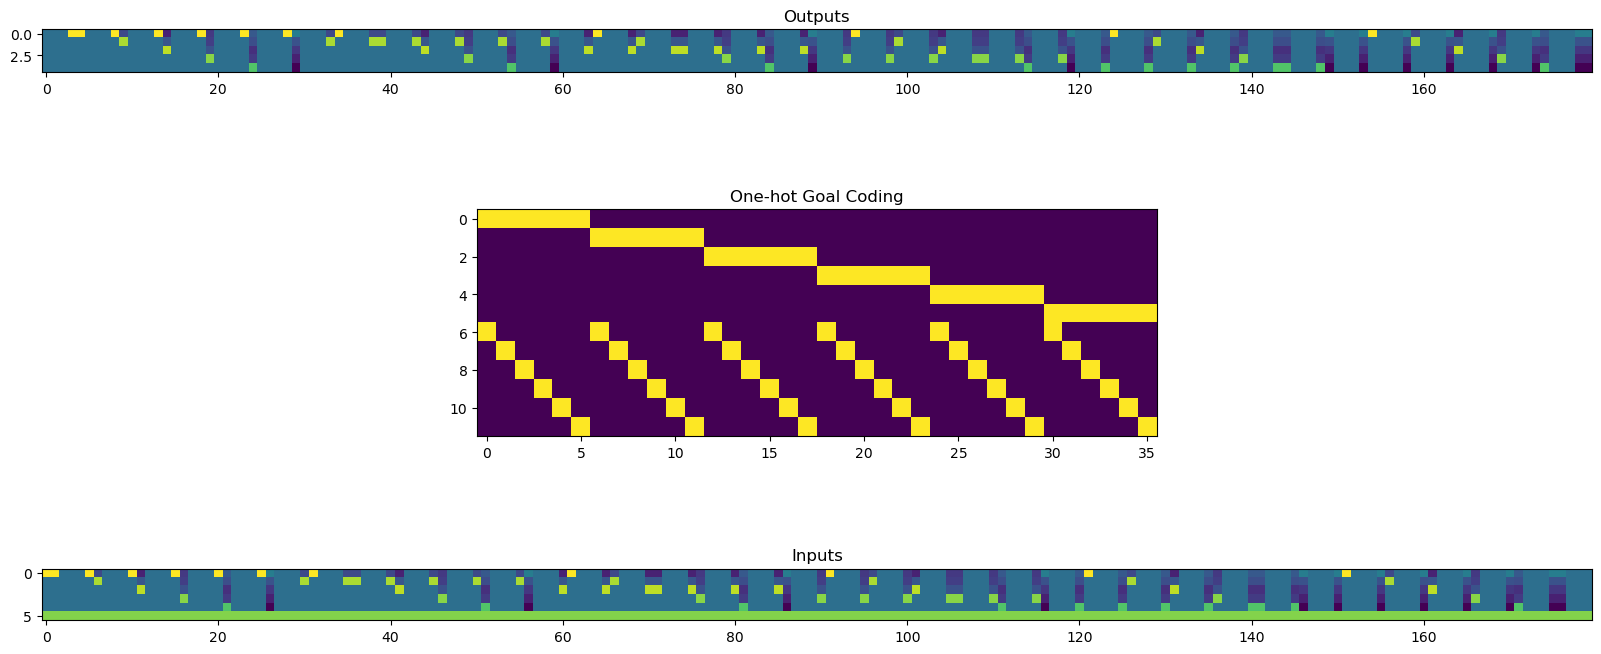

In [3]:
# Couple of functions, one to extract top (2) PCs, one to generate sequences
# At the bottom of the cell we programme in the sequence parameters (how many stimuli, do we include repeats, etc.)
# Then you generate the required inputs and outputs

def mean_angles(thetas):
    thetas = thetas/180*np.pi
    x = np.mean(np.cos(thetas))
    y = np.mean(np.sin(thetas))
    return np.arctan2(y, x)/np.pi*180
    
def get_2_PCs(vecs, num_eigs = 2):
    vecs = vecs - np.mean(vecs, axis = 1)[:,None]
    covar = vecs@vecs.T
    eigvals, eigvecs = np.linalg.eig(covar)
    
    ordering = np.argsort(eigvals)[::-1]
    #print(f"Propotion of Activity Kept: {np.sum(eigvals[ordering[:num_eigs]])/np.sum(eigvals)}")
    return np.real(eigvecs[:,ordering[:num_eigs]])

def dot_plot(g_encodings):
    dots = np.zeros([num_stim])
    for q in range(num_stim):
        dots[q] = g_encodings[:,q,0].T@g_encodings[:,q,1]
    plt.figure()
    plt.hist(dots, 6)
    plt.title('Dot Products')
    plt.xlabel('Dot Product')
    plt.ylabel('Count')

def generate_sequences(generators, seq_len, repeat, debias_outputs, debias_inputs):

    if seq_len > 4:
        print("SEQUENCES LONGER THAN 4 NOT IMPLEMENTED")

    num_stim, slot_dim = generators.shape
        
    task_len = 2*seq_len + 1
    
    if repeat == 0:
        num_tasks = int(math.factorial(num_stim)/(math.factorial(num_stim-seq_len)))
    else:
        num_tasks = num_stim**seq_len
    num_states = num_tasks*task_len
    
    outputs = np.zeros([slot_dim, num_states])
    inputs = np.zeros([slot_dim, num_states])
    regression_targets = np.zeros([num_stim*seq_len, num_tasks])

    # Must be a smarter way than this dumbness...
    if seq_len == 1:
        counter = 0
        task_counter = 0
        for q in range(num_states):
            inputs[:, counter] = generators[q,:]
            counter += 1
    
            counter += 1
            outputs[:, counter] = generators[q,:]
            counter += 1
    
            regression_targets[q, task_counter] = 1
            task_counter += 1
    
    if seq_len == 2:
        counter = 0
        task_counter = 0
        for q in range(num_stim):
            for q_p in range(num_stim):
                if repeat==0 and q_p == q:
                    continue
                inputs[:, counter] = generators[q,:]
                counter += 1
                inputs[:, counter] = generators[q_p,:]
                counter += 1
    
                counter += 1
                
                outputs[:, counter] = generators[q,:]
                counter += 1
                outputs[:, counter] = generators[q_p,:]
                counter += 1
    
                regression_targets[q, task_counter] = 1
                regression_targets[q_p+num_stim, task_counter] =  1
                task_counter += 1
                
    if seq_len == 3:
        counter = 0
        task_counter = 0
        for q in range(num_stim):
            for q_p in range(num_stim):
                for q_pp in range(num_stim):
                    if repeat==0:
                        if q == q_p or q_p == q_pp or q == q_pp:
                            continue
                    inputs[:, counter] = generators[q,:]
                    counter += 1
                    inputs[:, counter] = generators[q_p,:]
                    counter += 1
                    inputs[:, counter] = generators[q_pp,:]
                    counter += 1
    
                    counter += 1
    
                    outputs[:, counter] = generators[q,:]
                    counter += 1
                    outputs[:, counter] = generators[q_p,:]
                    counter += 1
                    outputs[:, counter] = generators[q_pp,:]
                    counter += 1
    
                    regression_targets[q, task_counter] = 1
                    regression_targets[q_p+num_stim, task_counter] =  1
                    regression_targets[q_pp+2*num_stim, task_counter] =  1
                    task_counter += 1
                    
    if seq_len == 4:
        counter = 0
        task_counter = 0
        for q in range(num_stim):
            for q_p in range(num_stim):
                for q_pp in range(num_stim):
                    for q_ppp in range(num_stim):
                        if repeat==0:
                            if q == q_p or q_p == q_pp or q == q_pp or q == q_ppp or q_p == q_ppp or q_pp == q_ppp:
                                continue
                        inputs[:, counter] = generators[q,:]
                        counter += 1
                        inputs[:, counter] = generators[q_p,:]
                        counter += 1
                        inputs[:, counter] = generators[q_pp,:]
                        counter += 1
                        inputs[:, counter] = generators[q_ppp,:]
                        counter += 1
                        
                        counter += 1
        
                        outputs[:, counter] = generators[q,:]
                        counter += 1
                        outputs[:, counter] = generators[q_p,:]
                        counter += 1
                        outputs[:, counter] = generators[q_pp,:]
                        counter += 1
                        outputs[:, counter] = generators[q_ppp,:]
                        counter += 1
                            
                        regression_targets[q, task_counter] = 1
                        regression_targets[q_p+num_stim, task_counter] =  1
                        regression_targets[q_pp+2*num_stim, task_counter] =  1
                        regression_targets[q_ppp+3*num_stim, task_counter] =  1
                        task_counter += 1
    
    if debias_outputs == 1:
        if np.sum(np.abs(np.mean(outputs, axis = 1)) > 0.0001):
            print('DEBIASING OUTPUTS')
            outputs = outputs - np.mean(outputs, axis = 1)[:,None]
    elif debias_outputs != 0:
        print('SHIFTING OUTPUTS')
        outputs = outputs - debias
    
    if debias_inputs == 1:
        if np.sum(np.abs(np.mean(inputs, axis = 1)) > 0.0001):
            print('DEBIASING INPUTS')
            inputs = inputs - np.mean(inputs, axis = 1)[:,None]
    elif debias_inputs != 0:
        print('SHIFTING INPUTS')
        inputs = inputs - debias
    
    inputs = np.vstack([inputs, np.ones([1, num_states])/np.sqrt(2)])
    
    plt.figure(figsize = (20,10))
    plt.subplot(3,1,1)
    plt.title('Outputs')
    plt.imshow(outputs)
    plt.subplot(3,1,2)
    plt.imshow(regression_targets)
    plt.title('One-hot Goal Coding')
    plt.subplot(3,1,3)
    plt.imshow(inputs)
    plt.title('Inputs')

    return inputs, outputs, regression_targets, num_states, task_len

num_stim = 6 # Number of Stimuli
seq_len = 2 # Seq length
repeat = 1 # Do you want to include repeats?
debias_outputs = 0 # Do you want to debias the outputs? Leave this at 
debias_inputs = 0 # Do you want to debias the inputs?
data_option = 2 # 0 for 1-hot, 1 for sine and cosine, 2 for loaded from data old, 3 for new from data, 4 for exact from data

if data_option == 0:
    generators = np.eye(num_stim)
elif data_option == 1:
    thetas = [2*np.pi/num_stim*i for i in range(num_stim)]
    generators = np.stack([np.cos(thetas), np.sin(thetas)]).T
elif data_option == 2:
    generators = np.load('./best_fitting_symmetric_generators.npy')
    num_stim = generators.shape[0]
elif data_option == 3:
    generators = np.load('./more_nice_generators.npy')
    num_stim = generators.shape[0]
elif data_option == 4:
    generators = np.load('./exact_from_data.npy').T
    num_stim = generators.shape[0]
data_dim = generators.shape[1]


if generators.shape[0] != num_stim:
    print("NOT CORRECT num_stim!!!")

 
inputs, outputs, regression_targets, D, task_len = generate_sequences(generators, seq_len, repeat, debias_outputs, debias_inputs)

Text(0.5, 1.0, 'Inputs')

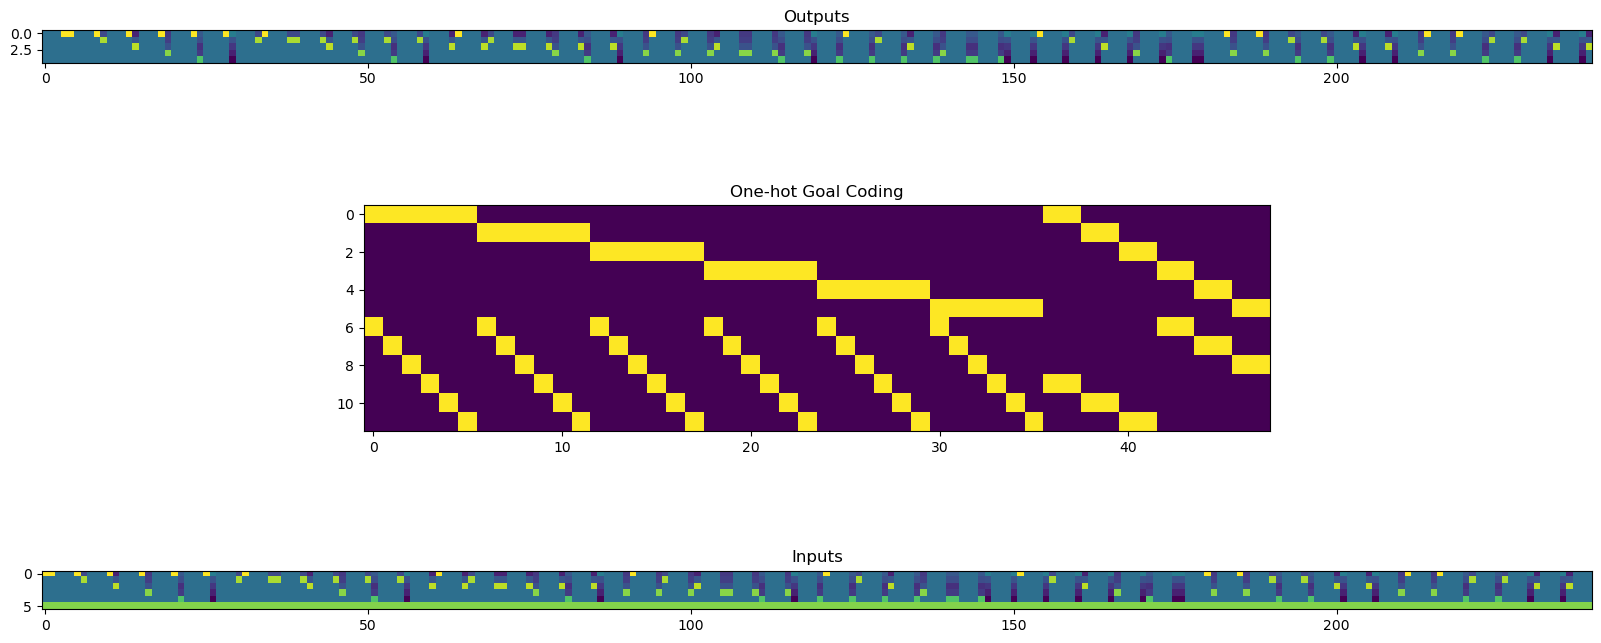

In [4]:
# We add an extra two extra copies of opposite data
correlate_things = 1
num_copies = 2
if correlate_things:
    num_trials = num_stim*(num_stim - (1-repeat))
    duplicate_indices = []
    for d in range(num_trials):
        if np.where(regression_targets[:num_stim,d] == 1)[0] == np.mod(np.where(regression_targets[num_stim:,d] == 1)[0] + int(num_stim/2), num_stim):
            for copy in range(num_copies):
                duplicate_indices.append(d)

    regression_targets = np.hstack([regression_targets, regression_targets[:,duplicate_indices]])
    D = D + num_stim*num_copies*task_len

    adding_inputs = []
    adding_outputs = []
    for duplicate in duplicate_indices:
        adding_inputs.append(inputs[:,duplicate*task_len:(duplicate+1)*task_len])
        adding_outputs.append(outputs[:,duplicate*task_len:(duplicate+1)*task_len])
    adding_inputs = np.hstack(adding_inputs)
    adding_outputs = np.hstack(adding_outputs)

    inputs = np.hstack([inputs, adding_inputs])
    outputs = np.hstack([outputs, adding_outputs])
    
plt.figure(figsize = (20,10))
plt.subplot(3,1,1)
plt.title('Outputs')
plt.imshow(outputs)
plt.subplot(3,1,2)
plt.imshow(regression_targets)
plt.title('One-hot Goal Coding')
plt.subplot(3,1,3)
plt.imshow(inputs)
plt.title('Inputs')

I0000 00:00:1725990444.561189       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


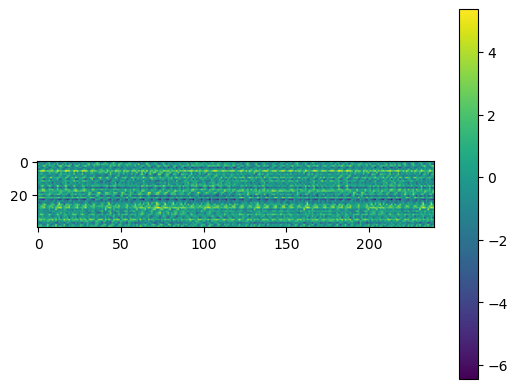

In [5]:
# Randomly initialise parameters and generate a representation
# Number of neurons:
N = 40
W = np.random.normal(0,1, [N,N])
W, S, V = np.linalg.svd(W) # Initialise with orthogonal matrix
I = np.random.normal(0,1, [N,data_dim+1])
g = np.zeros([N, D])
params = {'W': W, 'I': I}

@jit
def generate_rep(params, inputs, g):
    g = g.at[:,::task_len].set(params["I"]@inputs[:,::task_len])
    for t in range(1,task_len):
        g = g.at[:,t::task_len].set(params["I"]@inputs[:,t::task_len] + params["W"]@g[:,t-1::task_len])
    return g

plt.imshow(generate_rep(params, inputs, jnp.zeros([N, D])))
plt.colorbar()

In [6]:
# Set up the losses
bias = 1 # Include bias in the readout linear regression?
required_offset = 0
act_reg = 0

if bias == 0:
    @jit
    def generate_rep(params, inputs):
        g = jnp.zeros([N, D])
        g = g.at[:,::task_len].set(params["I"]@inputs[:,::task_len])
        for t in range(1,task_len):
            g = g.at[:,t::task_len].set(params["I"]@inputs[:,t::task_len] + params["W"]@g[:,t-1::task_len])
        return g
else:
    @jit
    def generate_rep(params, inputs):
        g = jnp.zeros([N, D])
        g = g.at[:,::task_len].set(params["I"]@inputs[:,::task_len])
        for t in range(1,task_len):
            g = g.at[:,t::task_len].set(params["I"]@inputs[:,t::task_len] + params["W"]@g[:,t-1::task_len])

        g_bias = jnp.vstack([g, jnp.ones(g.shape[1])[None,:]])
        return g_bias   


@jit
def loss_pos(g):
    g_neg = (g - jnp.abs(g))/2
    L_pos = -jnp.sum(g_neg)
    return L_pos

@jit
def loss_weight(W):
    return jnp.sum(jnp.power(W, 2))

@jit
def loss_weight_I(I):
    return jnp.sum(jnp.power(I[:,:-1],2))

if bias == 0:
    @jit
    def generate_R(g, outputs):
        mat0 = jnp.matmul(g, g.T)
        mat1 = jnp.matmul(g, outputs.T)
        mat2 = jnp.matmul(jnp.linalg.inv(mat0 + 0.0001*jnp.eye(N)), mat1)
        return mat2     
    
    @jit
    def loss_R(R):
        return jnp.linalg.norm(generate_R(g, targets))**2

    if act_reg == 0:
        @jit
        def loss_act(g):
            return jnp.sum(jnp.power(g, 2))
    else:
        @jit
        def loss_act(g):
            return jnp.sum(jnp.abs(jnp.power(g, act_reg)))
else:
    @jit
    def generate_R(g, outputs):
        mat0 = jnp.matmul(g, g.T)
        mat1 = jnp.matmul(g, outputs.T)
        mat2 = jnp.matmul(jnp.linalg.inv(mat0 + 0.0001*jnp.eye(N+1)), mat1)
        return mat2

    @jit
    def loss_R(R):
        R_sub = R[:-1,:]
        return jnp.sum(jnp.power(R_sub, 2))

    if act_reg == 0:
        @jit
        def loss_act(g):
            return jnp.sum(jnp.power(g[:-1,:] - required_offset, 2))
    else:
        @jit
        def loss_act(g):
            return jnp.sum(jnp.abs(jnp.power(g[:-1,:], act_reg)))

@jit
def loss_fit(g, R, outputs):
    preds = R.T@g
    #preds_demeaned = preds - np.mean(preds, axis = 1)[:,None]
    return jnp.linalg.norm(outputs - preds) 


mu_fit = 100000
mu_G = 500
mu_W = 0.005
mu_R = 0.005
mu_pos = 100000
fit_thresh = 0.01

@jit
def loss(params, inputs, outputs):
    g = generate_rep(params, inputs)
    R = generate_R(g, outputs)
    
    return mu_fit*jnn.relu(loss_fit(g, R, outputs)-fit_thresh) + mu_G*loss_act(g) + mu_W*loss_weight(params["W"]) + mu_R*(loss_weight_I(params["I"]) + loss_R(R)) + mu_pos*loss_pos(g)

@jit
def update(params, inputs, outputs, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, inputs, outputs)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, value

random_seed = 43144231421324431
learning_rate = 1e-5

re_init = 1
if re_init:
    key = random.PRNGKey(random_seed)
    W = random.normal(key, (N,N))*0.1
    W, S, V = jnp.linalg.svd(W)
    I = random.normal(key, (N, data_dim+1))*0.1
    optimizer = optax.adam(learning_rate)
    # Obtain the `opt_state` that contains statistics for the optimizer.
    params = {'W': W, 'I': I}
    opt_state = optimizer.init(params)
print(loss(params, inputs, outputs))
min_loss = np.infty

63202330.0


In [ ]:
# Optimisation, run and re-run until it stops hitting new records

T = 10000000
print_iter = 10000

for t in range(T):
    params, opt_state, loss = update(params, inputs, outputs, opt_state)

    if t % print_iter == 0:
        g = generate_rep(params, inputs)
        R = generate_R(g, outputs)

        L_f = loss_fit(g, R, outputs)
        L_a = loss_act(g)
        L_w = loss_weight(params["W"])
        L_R = loss_weight(R)
        L_p = loss_pos(g)
        L_I = loss_weight(params["I"])    

        min_this_step = 0

        #a, b, c, d = difference_analysis(g[:-bias,seq_len::task_len], regression_targets, seq_len, num_stim, num_eigs = 5, fig = False)
        print(f"Step {t}, Loss: {loss:.5f}, Fit: {L_f:.5f}, Act: {L_a:.5f}, Wei: {L_w:.5f}, R: {L_R:.5f}, Pos: {L_p:.5f}, I: {L_I:.5f}")#, Mean Ang: {np.mean(a)}")

    if loss < min_loss:
        params_best = params
        min_loss = loss
        if min_this_step == 0:
            g = generate_rep(params_best, inputs)
            #a, b, c, d = difference_analysis(g[:-bias,seq_len::task_len], regression_targets, seq_len, num_stim, num_eigs = 5, fig = False)

            print(f'New min! {loss}')#, Mean Ang: {np.mean(a)}')
            min_this_step = 1

Step 0, Loss: 63202328.00000, Fit: 0.04039, Act: 277.18265, Wei: 39.99897, R: 49.62940, Pos: 630.24603, I: 2.36313
New min! 63202328.0
Step 10000, Loss: 1551582.75000, Fit: 0.01258, Act: 234.05084, Wei: 36.46289, R: 361.90204, Pos: 14.33721, I: 1.04759
New min! 1551582.75
Step 20000, Loss: 76043.33594, Fit: 0.01069, Act: 49.46290, Wei: 34.24929, R: 701.71960, Pos: 0.51197, I: 0.67834
New min! 76043.3359375
Step 30000, Loss: 11011.27246, Fit: 0.01358, Act: 21.29654, Wei: 33.66917, R: 1097.11206, Pos: 0.00000, I: 0.41139
New min! 11002.3671875
Step 40000, Loss: 6948.18018, Fit: 0.01563, Act: 12.75016, Wei: 34.04848, R: 1299.60303, Pos: 0.00000, I: 0.26973
New min! 6936.1826171875
Step 50000, Loss: 5166.19971, Fit: 0.01658, Act: 9.00524, Wei: 34.60040, R: 1381.20068, Pos: 0.00001, I: 0.19241
New min! 5159.83544921875
Step 60000, Loss: 4201.56104, Fit: 0.01669, Act: 7.04121, Wei: 35.19242, R: 1394.63818, Pos: 0.00000, I: 0.14731
New min! 4193.4501953125
Step 70000, Loss: 3601.76782, Fit: 0

In [39]:
if False:
    params_new = params
    #params_new["I"] *= 2
    params_new["W"] *= 1.1
    params = params_new

In [40]:
#name = 'best_data_fitting_params_extreme_params.npy'
name = False
#name = 'good_new_params.npy'
#name = 'crazy_three_seq_params.npy'
if name:
    np.save(name, params_best)

NameError: name 'Flase' is not defined

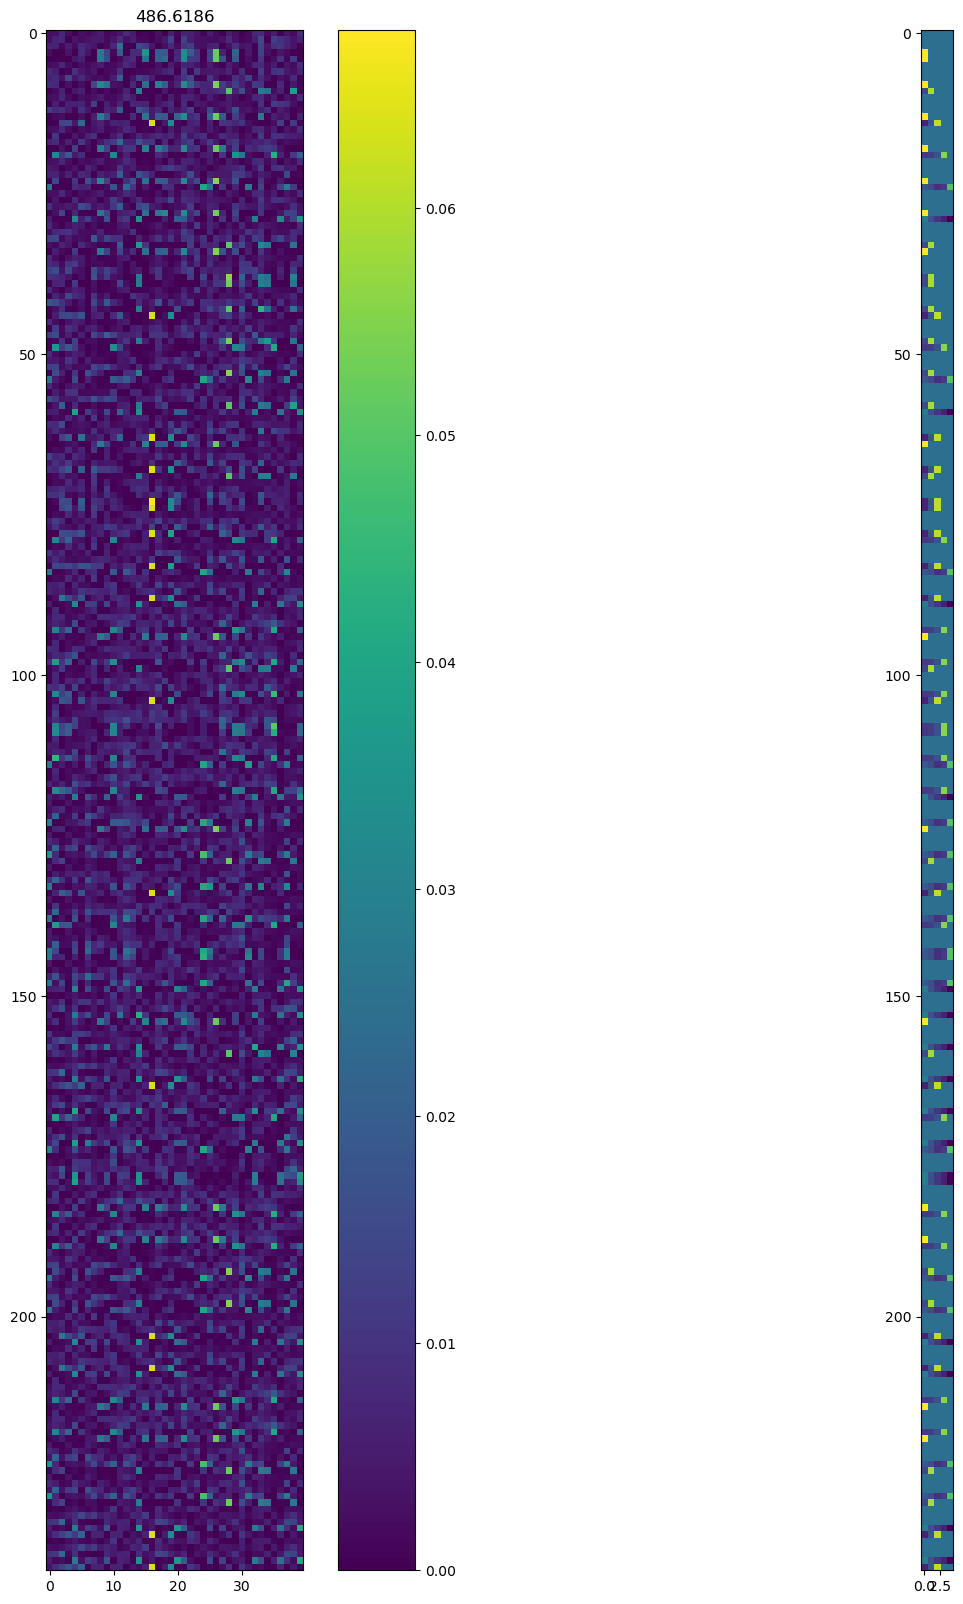

In [41]:
# Okay, so now we have our representation, this cell just plots it and checks it is predicting correctly
g = generate_rep(params_best, inputs)
R = generate_R(g, outputs)
predictions = R.T@g

plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(g[:-bias,:].T)
plt.title(min_loss)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(predictions.T)

# Data Analysis Section

We now have our delay period activity for this biased set of sequences

We're going to do a series of things.

First we'll do the naive analysis on a set of unbiased (sampled with replacement) sequences. This will give us our ground truth. We can do this in simulation, but I don't think you can in experiments? It's also a very wierd operation, because it means the data we generate this way has negative firing rates even if we've placed a positivity constraint on the original representation, something the standard representation has been optimised to avoid. Another reason why having a method that works only on the actually optimised rates is a good thing.

Then we'll do the naive analysis on the biasedly-sampled sequences, and show its weird.

Finally, we'll apply our funky thing to the biasedly-sampled sequences, and show it recovers the original.

In [42]:
%pwd

'/Users/will/Documents/Rep_Theory_Notebooks/Music_Boxes'

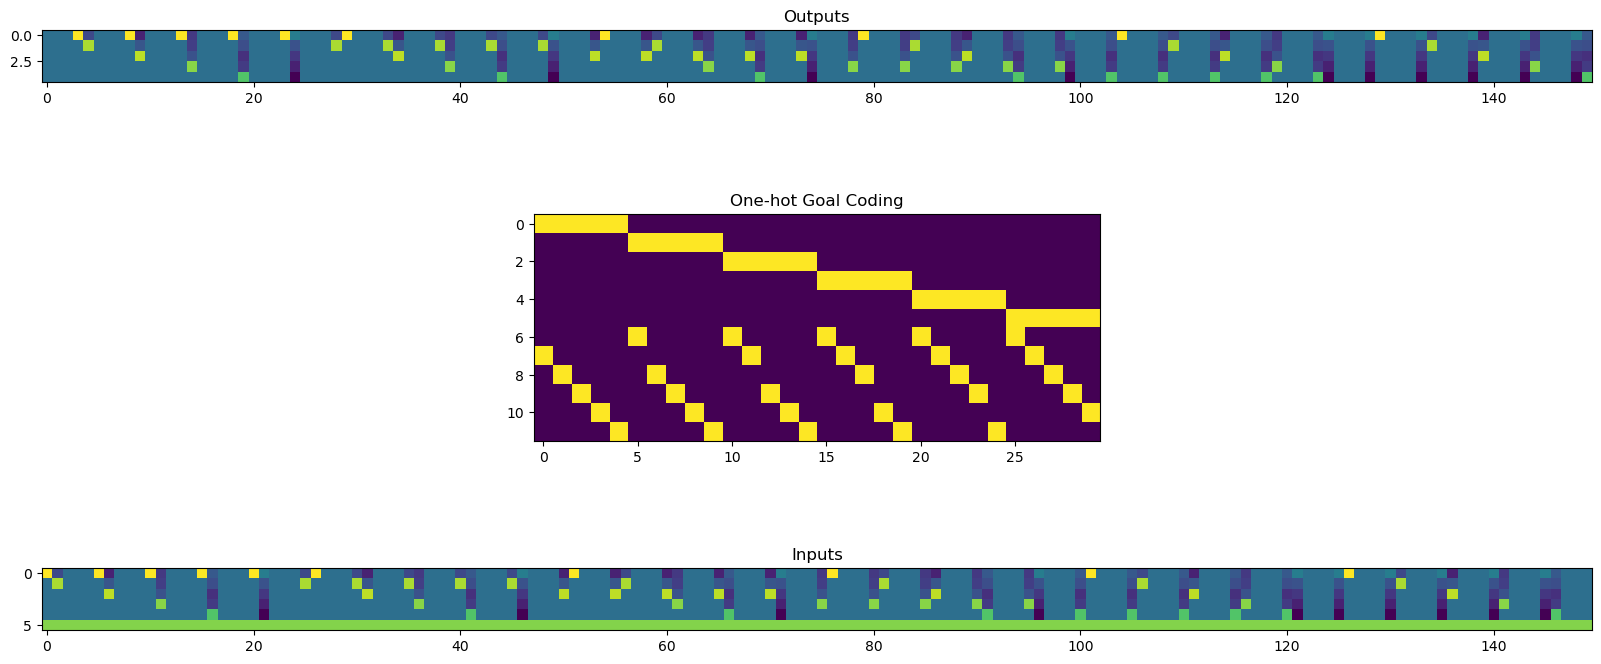

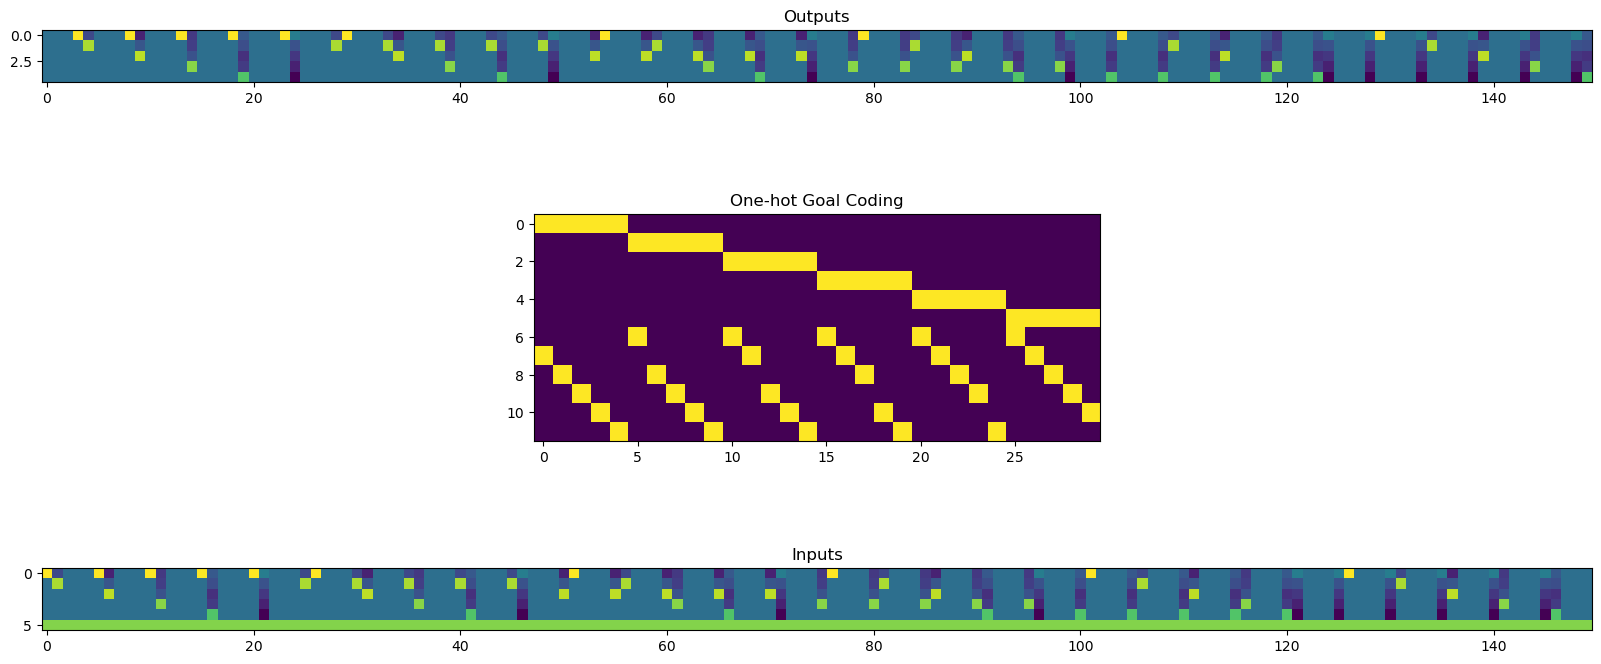

In [50]:
correlate_things = 0
if True:
    params_best = np.load('best_data_fitting_params_extreme_params.npy', allow_pickle=True)
    params_best = params_best[()]
    params = params_best

    N = params_best['W'].shape[0]
    
    num_stim = 6 # Number of Stimuli
    seq_len = 2 # Seq length
    repeat = 0 # Do you want to include repeats?
    debias_outputs = 1 # Do you want to debias the outputs? Leave this at 
    debias_inputs = 1 # Do you want to debias the inputs?
    data_option = 2 # 0 for 1-hot, 1 for sine and cosine, 2 for loaded from data
    
    if data_option == 0:
        generators = np.eye(num_stim)
    elif data_option == 1:
        thetas = [2*np.pi/num_stim*i for i in range(num_stim)]
        generators = np.stack([np.cos(thetas), np.sin(thetas)]).T
    elif data_option == 2:
        generators = np.load('/Users/will/Documents/Rep_Theory_Notebooks/XieDataAnalysis/best_fitting_symmetric_generators.npy')
        num_stim = generators.shape[0]
    data_dim = generators.shape[1]

inputs, outputs, regression_targets, D, task_len = generate_sequences(generators, seq_len, repeat, debias_outputs, debias_inputs)

if correlate_things:
    num_trials = num_stim*(num_stim - (1-repeat))
    duplicate_indices = []
    for d in range(num_trials):
        if np.where(regression_targets[:num_stim,d] == 1)[0] == np.mod(np.where(regression_targets[num_stim:,d] == 1)[0] + int(num_stim/2), num_stim):
            for copy in range(num_copies):
                duplicate_indices.append(d)

    regression_targets = np.hstack([regression_targets, regression_targets[:,duplicate_indices]])
    D = D + num_stim*num_copies*task_len

    adding_inputs = []
    adding_outputs = []
    for duplicate in duplicate_indices:
        adding_inputs.append(inputs[:,duplicate*task_len:(duplicate+1)*task_len])
        adding_outputs.append(outputs[:,duplicate*task_len:(duplicate+1)*task_len])
    adding_inputs = np.hstack(adding_inputs)
    adding_outputs = np.hstack(adding_outputs)

    inputs = np.hstack([inputs, adding_inputs])
    outputs = np.hstack([outputs, adding_outputs])

plt.figure(figsize = (20,10))
plt.subplot(3,1,1)
plt.title('Outputs')
plt.imshow(outputs)
plt.subplot(3,1,2)
plt.imshow(regression_targets)
plt.title('One-hot Goal Coding')
plt.subplot(3,1,3)
plt.imshow(inputs)
plt.title('Inputs')

if bias == 0:
    @jit
    def generate_rep_biased(params, inputs):
        g = jnp.zeros([N, D_biased])
        g = g.at[:,::task_len].set(params["I"]@inputs[:,::task_len])
        for t in range(1,task_len):
            g = g.at[:,t::task_len].set(params["I"]@inputs[:,t::task_len] + params["W"]@g[:,t-1::task_len])
        return g
else:
    @jit
    def generate_rep_biased(params, inputs):
        g = jnp.zeros([N, D_biased])
        g = g.at[:,::task_len].set(params["I"]@inputs[:,::task_len])
        for t in range(1,task_len):
            g = g.at[:,t::task_len].set(params["I"]@inputs[:,t::task_len] + params["W"]@g[:,t-1::task_len])

        g_bias = jnp.vstack([g, jnp.ones(g.shape[1])[None,:]])
        return g_bias   
g = generate_rep(params_best, inputs)
g_delay = g[:-1,2::task_len]

In [11]:
if bias == 0:
    @jit
    def generate_rep_unbiased(params, inputs):
        g = jnp.zeros([N, D_unbiased])
        g = g.at[:,::task_len].set(params["I"]@inputs[:,::task_len])
        for t in range(1,task_len):
            g = g.at[:,t::task_len].set(params["I"]@inputs[:,t::task_len] + params["W"]@g[:,t-1::task_len])
        return g
else:
    @jit
    def generate_rep_unbiased(params, inputs):
        g = jnp.zeros([N, D_unbiased])
        g = g.at[:,::task_len].set(params["I"]@inputs[:,::task_len])
        for t in range(1,task_len):
            g = g.at[:,t::task_len].set(params["I"]@inputs[:,t::task_len] + params["W"]@g[:,t-1::task_len])

        g_bias = jnp.vstack([g, jnp.ones(g.shape[1])[None,:]])
        return g_bias   

def weird_normalisations(g_here, choice, min_limit = 0.0000001):
    if choice > 0:
        g_here[:-bias,:] = g_here[:-bias,:] - np.mean(g_here[:-bias,:], axis = 1)[:,None]
        for neuron in range(g_here.shape[0]-1):
            if choice == 1:
                if np.mean(g_here[neuron,:]) > min_limit:
                    g_here[neuron,:] = g_here[neuron,:]/np.mean(g_here[neuron,:])
            elif choice == 2:
                if np.var(g_here[neuron,:]) > min_limit:
                    g_here[neuron,:] = g_here[neuron,:]/np.var(g_here[neuron,:])

    return g_here

ValueError: Incompatible shapes for broadcasting: (40, 60) and requested shape (40, 36)

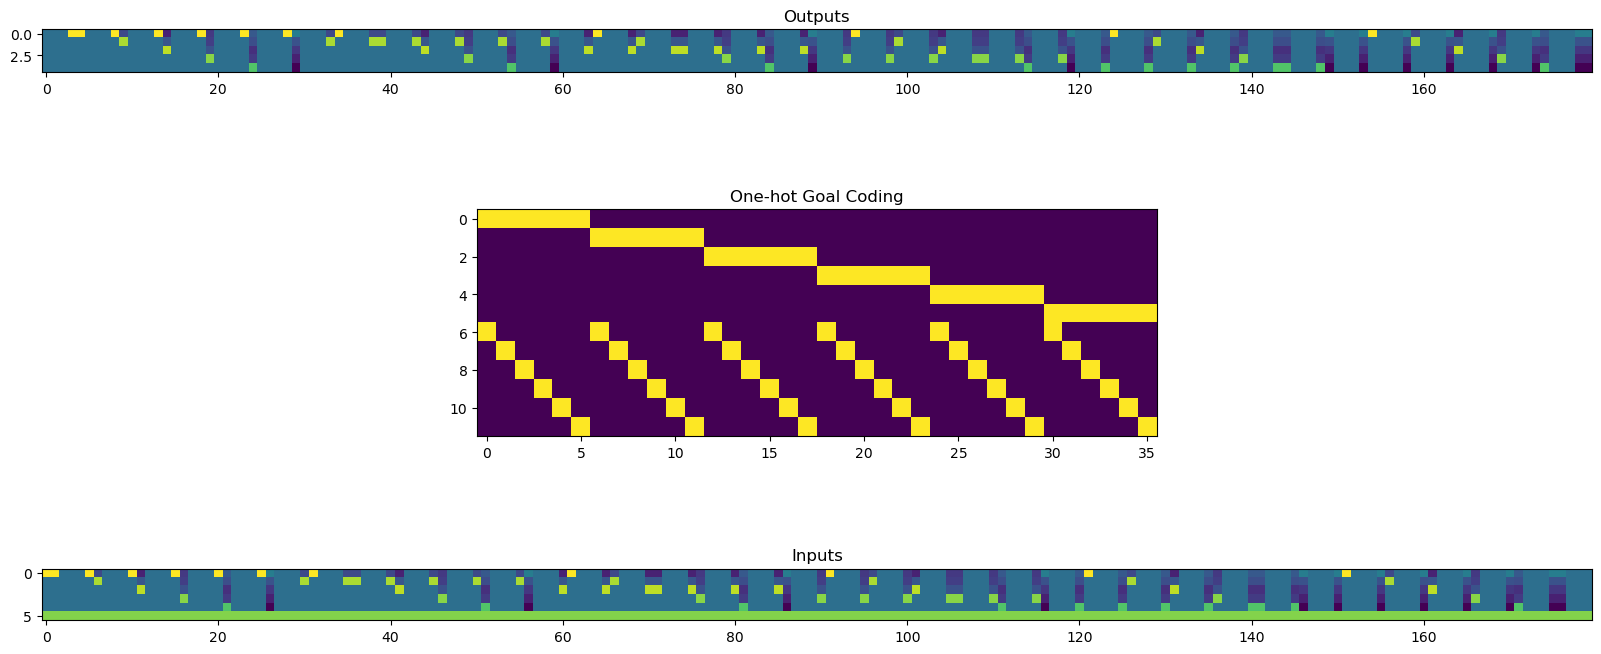

In [12]:
# Now test on correlated (or generally the opposite) data, our one should stay the same, the other one break?
inputs_unbiased, outputs_unbiased, regression_targets_unbiased, D_unbiased, task_len = generate_sequences(generators, seq_len, 1, debias_outputs, debias_inputs)

g_unbiased = generate_rep_unbiased(params_best, inputs_unbiased)
R_unbiased = generate_R(g_unbiased, outputs_unbiased)

predictions_unbiased = R_unbiased.T@g_unbiased

# Do some calcium imaging style preprocessing?
g_unbiased = np.array(g_unbiased)
choice = 0 # 0 for nothing, 2 for z scoring, 1 for dF/F
g = generate_rep_biased(params, inputs)
g_processed = np.array(g)
g_unbiased = weird_normalisations(g_unbiased, choice)
g_processed = weird_normalisations(g_processed, choice)

plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(g_unbiased[:-bias,:].T)
plt.title(min_loss)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(predictions_unbiased.T)

g_delay_unbiased = g_unbiased[:-bias,seq_len::task_len]
g_delay = g_processed[:-bias,seq_len::task_len]

Subspace Angles: [[65.0603858  71.03710692]]
[68.04874636]


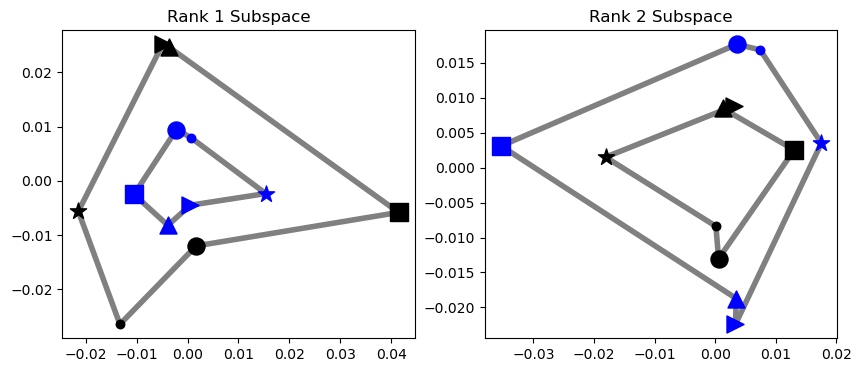

In [22]:
def naive_analysis(g_analysis, reg_tar, seq_len, num_stim, num_eigs = 2, fig = True):
    N = g_analysis.shape[0]
    avg_rep = np.zeros([N, seq_len, num_stim])
    PCs = np.zeros([N,seq_len,num_eigs])

    g_analysis = g_analysis - np.mean(g_analysis, axis = 1)[:,None]
    
    for seq_ind in range(seq_len):
        for stim_ind in range(num_stim):
            avg_rep[:,seq_ind,stim_ind] = np.mean(g_analysis[:,reg_tar[num_stim*seq_ind+stim_ind,:] == 1], axis = 1)
    
        PCs[:,seq_ind,:] = get_2_PCs(avg_rep[:,seq_ind,:], num_eigs = num_eigs)
    
    projections = np.zeros([num_eigs,num_stim,seq_len,seq_len])
    for seq_ind in range(seq_len):
        for seq_ind2 in range(seq_len):
            projections[:,:,seq_ind,seq_ind2] = PCs[:,seq_ind,:].T@avg_rep[:,seq_ind2,:]

    if fig:
    
        markers = ['.','o','s','^','>','*']
        colours = ['k', 'b', 'r']
    
        if num_eigs%2 == 0:
            plot_3D = 0
        else:
            plot_3D = 1
        plot_rows = int(np.floor(num_eigs/2))
        
        fig = plt.figure(figsize = (10,4*plot_rows))
        for r in range(seq_len):
            for plot in range(plot_rows):
                #print(r, plot, plot_rows)
                if plot == plot_rows - 1 and plot_3D:
                    num = plot_rows*100 + seq_len*10 + r+1+plot*seq_len
                    ax = fig.add_subplot(num, projection='3d')
                    if plot == 0:
                        plt.title(f'Rank {r+1} Subspace')
    
                    for rp in range(seq_len):
                        for q in range(num_stim):
                            ax.scatter(projections[0+2*plot,q,r,rp], projections[1+2*plot,q,r,rp], projections[2+2*plot,q,r,rp], s = 150, zorder=1, color = colours[rp], marker = markers[q])
                            ax.plot([projections[0+2*plot,q,r,rp], projections[0+2*plot,np.mod(q+1,num_stim),r,rp]], [projections[1+2*plot,q,r,rp], projections[1+2*plot,np.mod(q+1,num_stim),r,rp]], [projections[2+2*plot,q,r,rp], projections[2+2*plot,np.mod(q+1,num_stim),r,rp]], c='gray', lw = 4,zorder=0)
    
                else:
                    plt.subplot(plot_rows,seq_len,r+1+plot*seq_len)
                    if plot == 0:
                        plt.title(f'Rank {r+1} Subspace')
    
                    for rp in range(seq_len):
                        for q in range(num_stim):
                            plt.plot([projections[0+2*plot,q,r,rp], projections[0+2*plot,np.mod(q+1,num_stim),r,rp]], [projections[1+2*plot,q,r,rp], projections[1+2*plot,np.mod(q+1,num_stim),r,rp]], c='gray', lw = 4,zorder=0)
                            plt.scatter(projections[0+2*plot,q,r,rp], projections[1+2*plot,q,r,rp], s = 150, zorder=1, color = colours[rp], marker = markers[q])
        
    # Let's get the subspace angles
    subspace_angles = np.zeros([int((seq_len-1)*seq_len/2), num_eigs])
    counter = 0
    for r in range(seq_len):
        for r_p in range(r):
            dot_prod = PCs[:,r,:].T@PCs[:,r_p,:]
            U, S, V = np.linalg.svd(dot_prod)
            try:
                subspace_angles[counter, :] = np.arccos(S)/np.pi*180
            except:
                subspace_angles[counter,:] = S
            counter += 1

    if fig:
        print(f'Subspace Angles: {subspace_angles}')
    return subspace_angles, projections, avg_rep
    
angles, projections, avg_rep = naive_analysis(g_delay, regression_targets, seq_len, num_stim, num_eigs = 2)

print(np.mean(angles, axis= 1))
#if seq_len == 2:
#    dot_plot(g_encodings)

Best Fitting Scale Parameters: 0.08067509789357392
[[ 1.         -0.19343624 -0.24355978 -0.17800115 -0.18858674 -0.19641607]
 [-0.19343624  0.98951206 -0.21772901 -0.2149074  -0.17521202 -0.18822739]
 [-0.24355978 -0.21772901  0.99327064 -0.16624202 -0.16084476 -0.20489507]
 [-0.17800115 -0.2149074  -0.16624202  0.94899274 -0.20892581 -0.18091634]
 [-0.18858674 -0.17521202 -0.16084476 -0.20892581  0.92039926 -0.18682995]
 [-0.19641607 -0.18822739 -0.20489507 -0.18091634 -0.18682995  0.95728481]]


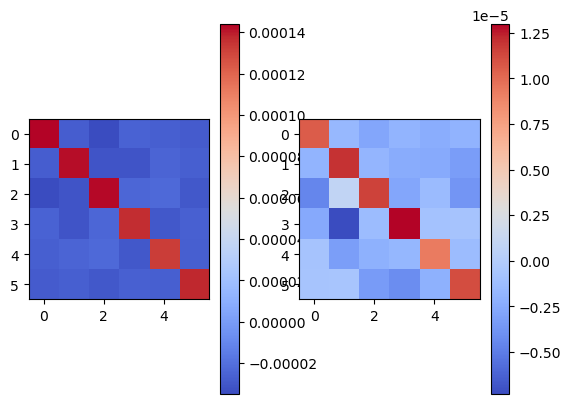

In [12]:
avg_rep_normalised = np.zeros(avg_rep.shape)
avg_rep_demeaned = avg_rep - np.mean(np.mean(avg_rep, axis = 2), axis = 1)[:,None,None]
for rank in range(seq_len):
    for stim in range(num_stim):
        avg_rep_normalised[:,rank,stim] = avg_rep_demeaned[:,rank,stim]#/np.linalg.norm(avg_rep_demeaned[:,rank,stim])

self_dot_mat = avg_rep_normalised[:,0,:].T@avg_rep_normalised[:,0,:]
plt.subplot(1,2,1)
plt.imshow(self_dot_mat,cmap='coolwarm')
plt.colorbar()

across_dot_mat = avg_rep_normalised[:,0,:].T@avg_rep_normalised[:,1,:]
plt.subplot(1,2,2)
plt.imshow(across_dot_mat,cmap='coolwarm')
plt.colorbar()

best_fitting_scale_parameter = np.sum(np.multiply(across_dot_mat, self_dot_mat))/np.sum(np.power(self_dot_mat, 2))
print(f'Best Fitting Scale Parameters: {best_fitting_scale_parameter}')
print(self_dot_mat/np.max(self_dot_mat))

[[ 1.         -0.22428064 -0.42327857 -0.31345692 -0.1312172   0.09223333]
 [-0.22428064  0.688067   -0.02780043 -0.15183784 -0.12528256 -0.15886553]
 [-0.42327857 -0.02780043  0.91621875  0.02798213 -0.21286605 -0.28025583]
 [-0.31345692 -0.15183784  0.02798213  0.72910092 -0.05849591 -0.23329238]
 [-0.1312172  -0.12528256 -0.21286605 -0.05849591  0.59484545 -0.06698373]
 [ 0.09223333 -0.15886553 -0.28025583 -0.23329238 -0.06698373  0.64716413]]


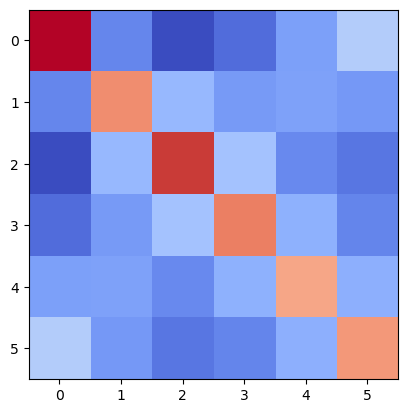

In [13]:
generator_dot = generators@generators.T
plt.imshow(generator_dot, cmap = 'coolwarm')
print(generator_dot)

Subspace Angles: [[70.87445819 71.46709105 71.62964169 73.07745716 74.21864023]]
72.25340894335963


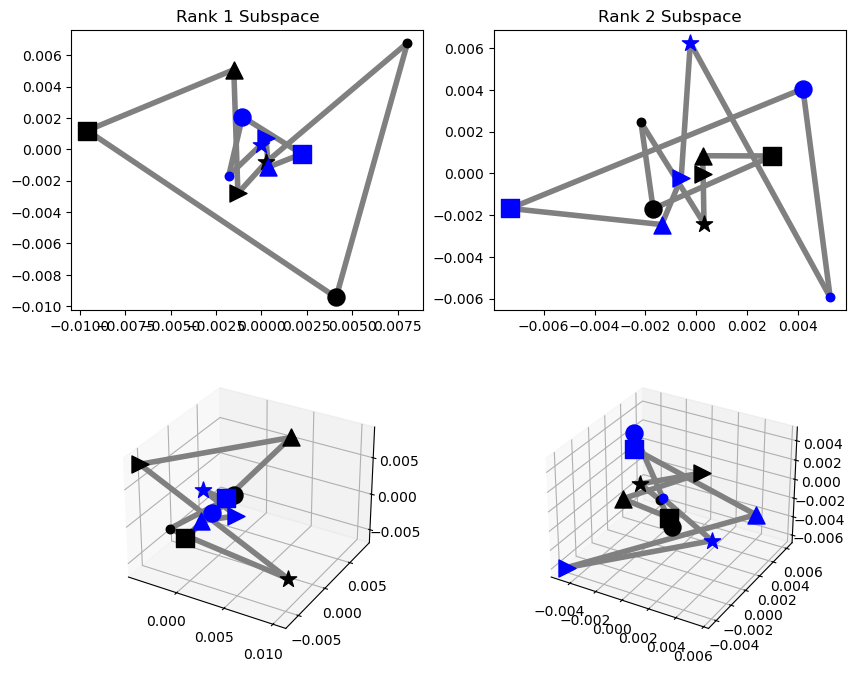

In [14]:
angles = naive_analysis(g_delay, regression_targets, seq_len, num_stim, num_eigs = 5)
print(mean_angles(angles[0]))

# Naive Analysis -> Not Naive

As you can see from the Naive analysis, applying it to the biased sequences vs. the unbiased gave very different results.

Both produced these planes with projections of one onto the other. But one produced predicted angles of 56 degrees, with massive anti-aligned projections, the other 85 degrees with small positive projections (and even those are removed if you add positivity into the loss)

Now we will show that the updated form of the analysis gets the same answer in the two cases.

Subspace Angles: [[81.57035082 82.93462848 84.49276356 84.65905833 85.17522614]]
83.76647935279085


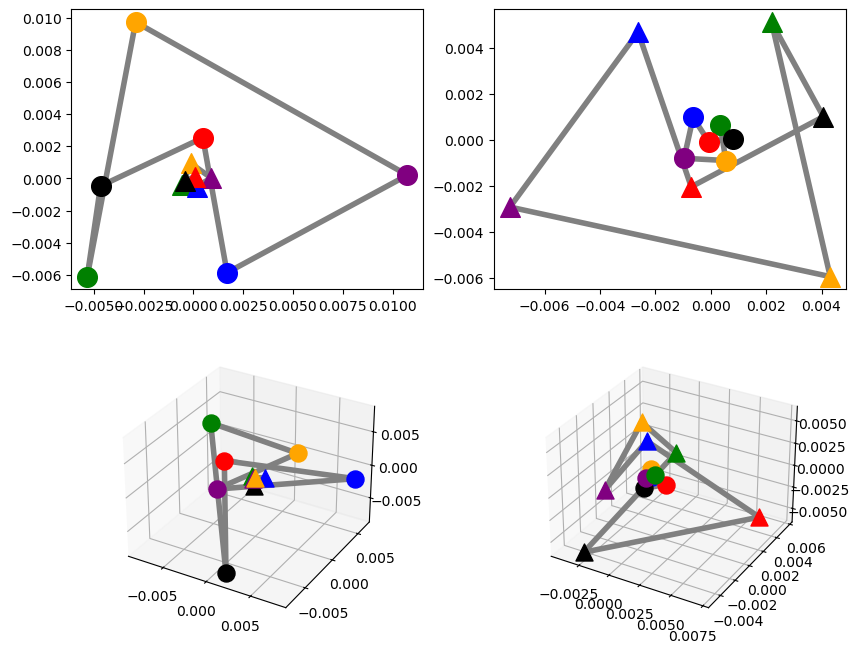

In [52]:
def difference_analysis(g_analysis, reg_tar, seq_len, num_stim, num_eigs = 2, fig = True):
    N = g_analysis.shape[0]
    
    # Now try our new extraction scheme. Get difference vectors for all pairs of points
    difference_vectors = np.zeros([N, num_stim, num_stim, seq_len])
    for q in range(num_stim):
        for qp in range(num_stim):
            for r in range(seq_len):
                q_in_r = reg_tar[r*num_stim + q,:] == 1
                qp_in_r = reg_tar[r*num_stim + qp,:] == 1
                q_not_in_others = np.all((reg_tar[np.delete(np.arange(q, seq_len*num_stim, num_stim), r),:] == 0), axis = 0)
                qp_not_in_others = np.all((reg_tar[np.delete(np.arange(qp, seq_len*num_stim, num_stim), r),:] == 0), axis = 0)
                averaging_indices_q = np.all(np.vstack([q_in_r, qp_not_in_others, q_not_in_others]), axis = 0)
                averaging_indices_qp = np.all(np.vstack([qp_in_r, qp_not_in_others, q_not_in_others]), axis = 0)
    
                difference_vectors[:,q,qp,r] = np.mean(g_analysis[:, averaging_indices_q], axis = 1) - np.mean(g_analysis[:, averaging_indices_qp], axis = 1)
        
    # Now extract a couple of PCs and calculate the angles between them?
    PCs = np.zeros([N, num_eigs, seq_len])
    for r in range(seq_len):
        difference_vectors_flat = np.zeros([N, int(num_stim*(num_stim-1)/2)])
        counter = 0
        for q in range(num_stim):
            for qp in range(q):
                difference_vectors_flat[:,counter] = difference_vectors[:,q,qp,r]
                counter += 1
        PCs[:,:,r] = get_2_PCs(difference_vectors_flat, num_eigs = num_eigs)
    
    # Let's get the subspace angles
    subspace_angles = np.zeros([int((seq_len-1)*seq_len/2), num_eigs])
    counter = 0
    for r in range(seq_len):
        for r_p in range(r):
            dot_prod = PCs[:,:,r].T@PCs[:,:,r_p]
            U, S, V = np.linalg.svd(dot_prod)
            try:
                subspace_angles[counter, :] = np.arccos(S)/np.pi*180
            except:
                subspace_angles[counter,:] = S
            counter += 1

    # Finally, let's reconstruct the activity from these difference vectors
    g_encodings = np.zeros([N, num_stim, seq_len])
    projections = np.zeros([num_eigs, num_stim, seq_len, seq_len])
    for seq_ind in range(seq_len):
        g_encodings[:,:,seq_ind] = difference_vectors[:,0,:,seq_ind] - np.mean(difference_vectors[:,0,:,seq_ind],axis = 1)[:,None]

    for seq_ind in range(seq_len):
        for seq_indp in range(seq_len):
            projections[:,:,seq_ind, seq_indp] = PCs[:,:,seq_ind].T@g_encodings[:,:,seq_indp]

    if fig:
        markers = ['o', '^']
        colours = ['green', 'orange', 'purple', 'blue','red','black']
    
        if num_eigs%2 == 0:
            plot_3D = 0
        else:
            plot_3D = 1
        plot_rows = int(np.floor(num_eigs/2))
        
        fig = plt.figure(figsize = (10,4*plot_rows))
        for r in range(seq_len):
            for plot in range(plot_rows):
                if plot == plot_rows - 1 and plot_3D:
                    num = plot_rows*100 + seq_len*10 + r+1+plot*seq_len
                    ax = fig.add_subplot(num, projection='3d')
                    if plot == 0:
                        plt.title(f'Rank {r+1} Subspace')
    
                    for rp in range(seq_len):
                        for q in range(num_stim):
                            ax.scatter(projections[0+2*plot,q,r,rp], projections[1+2*plot,q,r,rp], projections[2+2*plot,q,r,rp], s = 150, zorder=1, color = colours[q], marker = markers[rp])
                            ax.plot([projections[0+2*plot,q,r,rp], projections[0+2*plot,np.mod(q+1,num_stim),r,rp]], [projections[1+2*plot,q,r,rp], projections[1+2*plot,np.mod(q+1,num_stim),r,rp]], [projections[2+2*plot,q,r,rp], projections[2+2*plot,np.mod(q+1,num_stim),r,rp]], c='gray', lw = 4,zorder=0)
    
                else:
                    plt.subplot(plot_rows,seq_len,r+1+plot*seq_len)
                    if plot == 0:
                        #plt.title(f'Rank {r+1} Subspace')
                        cfes = 0
                        
                    for rp in range(seq_len):
                        for q in range(num_stim):
                            plt.plot([projections[0+2*plot,q,r,rp], projections[0+2*plot,np.mod(q+1,num_stim),r,rp]], [projections[1+2*plot,q,r,rp], projections[1+2*plot,np.mod(q+1,num_stim),r,rp]], c='gray', lw = 4,zorder=0)
                            plt.scatter(projections[0+2*plot,q,r,rp], projections[1+2*plot,q,r,rp], s = 200, zorder=1, color = colours[q], marker = markers[rp])

                    ax = plt.gca()
                    #ax.axis('off')
        print(f'Subspace Angles: {subspace_angles}')
    return subspace_angles, difference_vectors, g_encodings, projections

subspace_angles, difference_vectors, g_encodings, projections = difference_analysis(g_delay, regression_targets, seq_len, num_stim, num_eigs = 5)
print(mean_angles(subspace_angles))

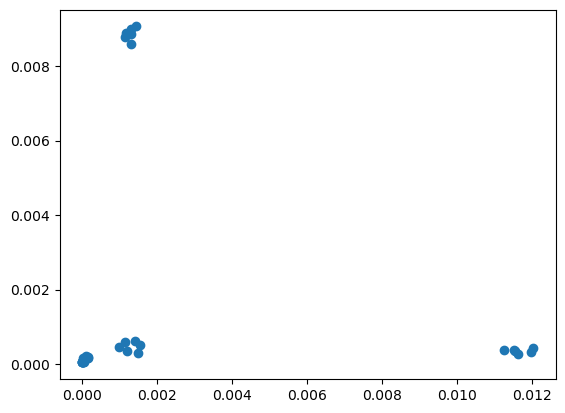

In [58]:
neuron_rank_tuning = np.zeros([N, 2])
for rank in range(2):
    for neuron in range(N):
        neuron_rank_tuning[neuron,rank] = np.linalg.norm(g_encodings[neuron,:,rank])
        
plt.scatter(neuron_rank_tuning[:,0], neuron_rank_tuning[:,1])

np.save('../../modular/data/neuron_rank_tuning_wo_replace.npy',neuron_rank_tuning)

In [56]:
%pwd

'/Users/will/Documents/Rep_Theory_Notebooks/Music_Boxes'

In [45]:
subspace_sizes = np.array([np.linalg.norm(g_encodings[:,:,i]) for i in range(2)])
best_relative_fit = subspace_sizes[0]/subspace_sizes[1]
best_relative_fit

1.4856122505850153

Best Fitting Scale Parameters: -0.023066370093537635
m_best = -0.0009267488188011747


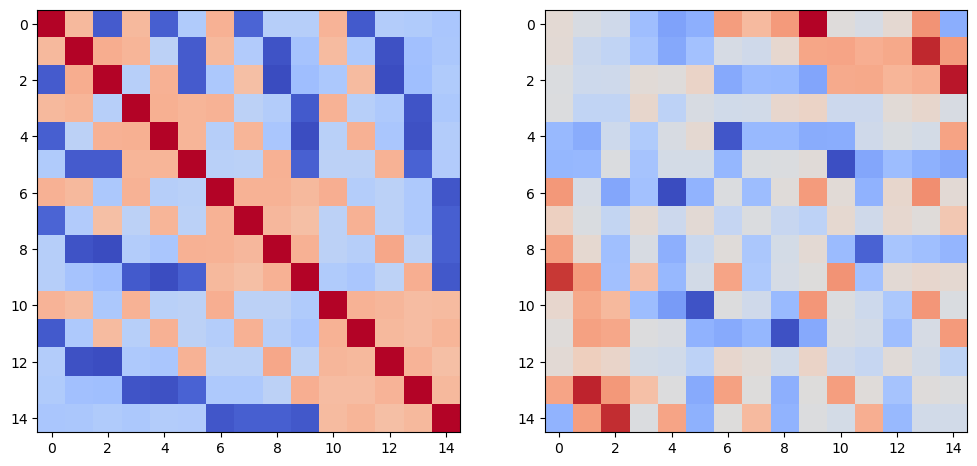

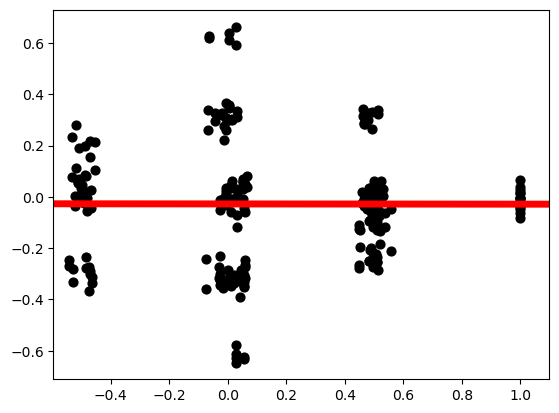

In [46]:
self_dot_mat = np.zeros([15, 15])
across_dot_mat = np.zeros([15, 15])
cosine_sim = 1
counter1 = -1
for theta1 in range(6):
    for theta2 in range(theta1):
        counter1 += 1
        counter2 = -1
        for theta1p in range(6):
            for theta2p in range(theta1p):
                counter2 += 1
                if cosine_sim == 0:
                    self_dot_mat[counter1, counter2] = difference_vectors[:,theta1, theta2, 0].T@difference_vectors[:,theta1p, theta2p, 0]
                    across_dot_mat[counter1, counter2] = difference_vectors[:,theta1, theta2, 1].T@difference_vectors[:,theta1p, theta2p, 0]
                else:
                    self_dot_mat[counter1, counter2] = difference_vectors[:,theta1, theta2, 0].T@difference_vectors[:,theta1p, theta2p, 0]/(np.linalg.norm(difference_vectors[:,theta1, theta2, 0])*np.linalg.norm(difference_vectors[:,theta1p, theta2p, 0]))
                    across_dot_mat[counter1, counter2] = difference_vectors[:,theta1, theta2, 1].T@difference_vectors[:,theta1p, theta2p, 0]/(np.linalg.norm(difference_vectors[:,theta1, theta2, 1])*np.linalg.norm(difference_vectors[:,theta1p, theta2p, 0]))
plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(self_dot_mat,cmap='coolwarm')
#plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(across_dot_mat,cmap='coolwarm')
#plt.colorbar()

best_fitting_scale_parameter = np.sum(np.multiply(across_dot_mat, self_dot_mat))/np.sum(np.power(self_dot_mat, 2))
print(f'Best Fitting Scale Parameters: {best_fitting_scale_parameter}')

plt.figure()
plt.scatter(np.ndarray.flatten(self_dot_mat), np.ndarray.flatten(across_dot_mat), c='k', s=40 )

x = np.ndarray.flatten(self_dot_mat)
y = np.ndarray.flatten(across_dot_mat)

M_check = ( np.mean(np.multiply(x,y)) -  np.mean(x) * np.mean(y) ) / np.mean(np.power(x - np.mean(x),2))

b, m_best = np.poly1d(np.polyfit(x, y, 1))

offset = 1.5
plt.plot(np.hstack([np.min(x)*offset, np.unique(x), np.max(x)*offset]), np.poly1d(np.polyfit(x, y, 1))(np.hstack([np.min(x)*offset, np.unique(x), np.max(x)*offset])), lw = 5, c='r')
offset_2 =1.1
plt.xlim([np.min(x)*offset_2, np.max(x)*offset_2])
plt.ylim([np.min(y)*offset_2, np.max(y)*offset_2])

print(f'm_best = {M_check}')

In [102]:
num_samples = 100
relative_sizes = np.zeros([num_samples])
best_fit_grads = np.zeros([num_samples])

for sample in range(num_samples):
    neuron_subsample = int(g_delay_unbiased.shape[0]*0.7)
    neuron_subsample_indices = np.random.choice(g_delay_unbiased.shape[0], [neuron_subsample], replace=False)
    subspace_angles, difference_vectors, g_encodings, projections = difference_analysis(g_delay_unbiased[neuron_subsample_indices,:], regression_targets_unbiased, seq_len, num_stim, num_eigs = 5, fig = False)    
    subspace_sizes = np.array([np.linalg.norm(g_encodings[:,:,i]) for i in range(2)])
    relative_sizes[sample] = subspace_sizes[0]/subspace_sizes[1]

    self_dot_mat = np.zeros([15, 15])
    across_dot_mat = np.zeros([15, 15])
    cosine_sim = 1
    counter1 = -1
    for theta1 in range(6):
        for theta2 in range(theta1):
            counter1 += 1
            counter2 = -1
            for theta1p in range(6):
                for theta2p in range(theta1p):
                    counter2 += 1
                    if cosine_sim == 0:
                        self_dot_mat[counter1, counter2] = difference_vectors[:,theta1, theta2, 0].T@difference_vectors[:,theta1p, theta2p, 0]
                        across_dot_mat[counter1, counter2] = difference_vectors[:,theta1, theta2, 1].T@difference_vectors[:,theta1p, theta2p, 0]
                    else:
                        self_dot_mat[counter1, counter2] = difference_vectors[:,theta1, theta2, 0].T@difference_vectors[:,theta1p, theta2p, 0]/(np.linalg.norm(difference_vectors[:,theta1, theta2, 0])*np.linalg.norm(difference_vectors[:,theta1p, theta2p, 0]))
                        across_dot_mat[counter1, counter2] = difference_vectors[:,theta1, theta2, 1].T@difference_vectors[:,theta1p, theta2p, 0]/(np.linalg.norm(difference_vectors[:,theta1, theta2, 1])*np.linalg.norm(difference_vectors[:,theta1p, theta2p, 0]))

    b, m = np.poly1d(np.polyfit(np.ndarray.flatten(across_dot_mat), np.ndarray.flatten(self_dot_mat), 1))
    best_fit_grads[sample] = m

1.3503436154185524 1.3255301785575466
0.10819396215096214 0.016809207825763006
0.40529385365616716
0.05251946370201249


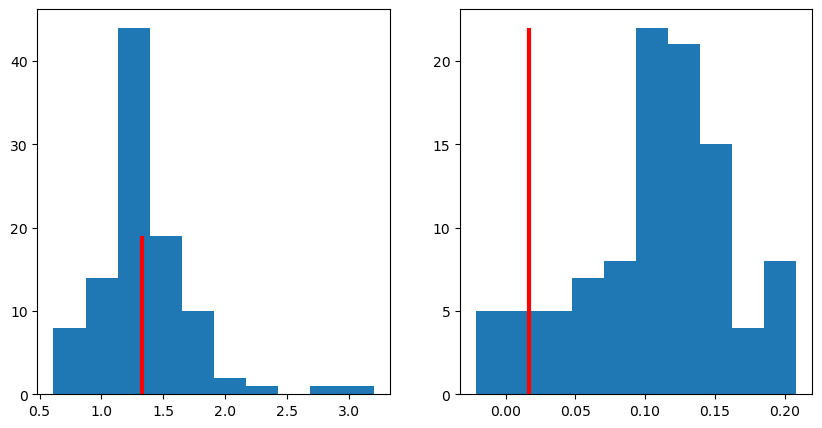

In [103]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
figey = plt.hist(relative_sizes)
plt.vlines(best_relative_fit, 0, biggest_count, 'r', lw = 3)
print(np.mean(relative_sizes), best_relative_fit)

plt.subplot(1,2,2)
figey = plt.hist(best_fit_grads)
biggest_count = np.max(figey[0])
plt.vlines(m_best, 0, biggest_count, 'r', lw = 3)
print(np.mean(best_fit_grads), m_best)

print(np.std(relative_sizes))
print(np.std(best_fit_grads))

Best Fitting Scale Parameters: 0.06640474566596016


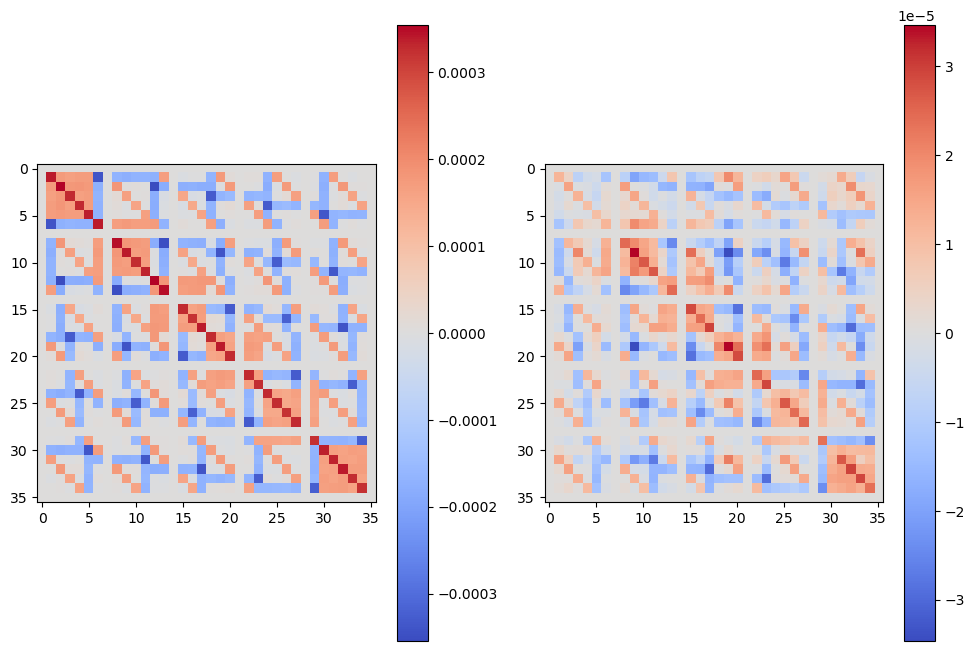

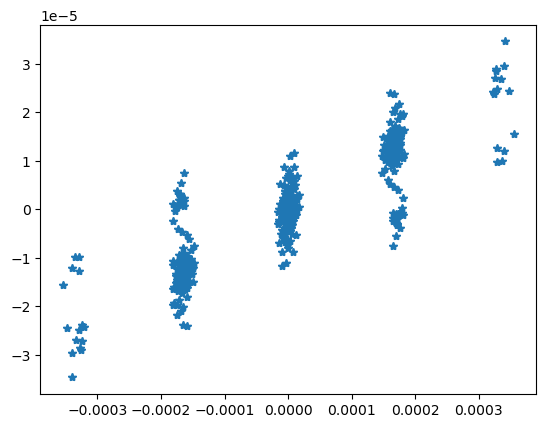

In [90]:

self_dot_mat = np.zeros([36, 36])
across_dot_mat = np.zeros([36, 36])
for theta1 in range(6):
    for theta2 in range(6):
        for theta1p in range(6):
            for theta2p in range(6):
                self_dot_mat[theta1*6 + theta2, theta1p*6 + theta2p] = difference_vectors[:,theta1, theta2, 0].T@difference_vectors[:,theta1p, theta2p, 0]
                across_dot_mat[theta1*6 + theta2, theta1p*6 + theta2p] = difference_vectors[:,theta1, theta2, 1].T@difference_vectors[:,theta1p, theta2p, 0]
plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(self_dot_mat,cmap='coolwarm')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(across_dot_mat,cmap='coolwarm')
plt.colorbar()

best_fitting_scale_parameter = np.sum(np.multiply(across_dot_mat, self_dot_mat))/np.sum(np.power(self_dot_mat, 2))
print(f'Best Fitting Scale Parameters: {best_fitting_scale_parameter}')

plt.figure()
plt.plot(np.ndarray.flatten(self_dot_mat), np.ndarray.flatten(across_dot_mat), '*')


Best Fitting Scale Parameters: 0.10690234491866549


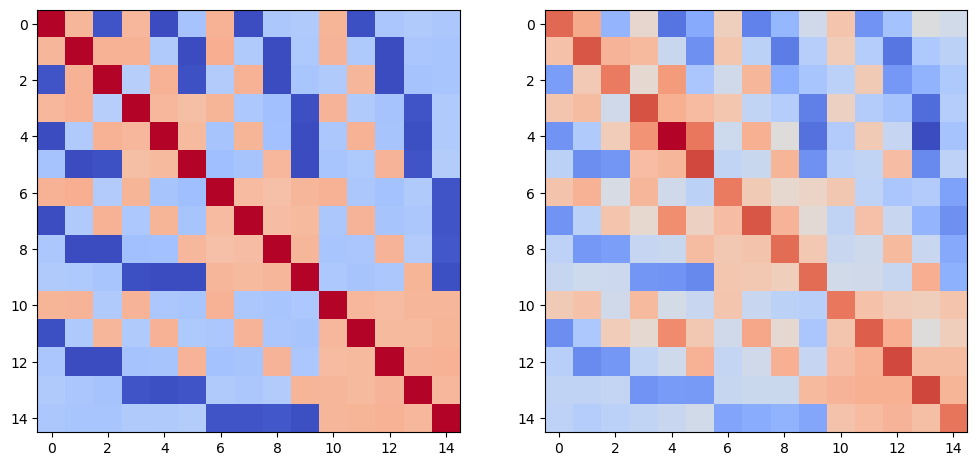

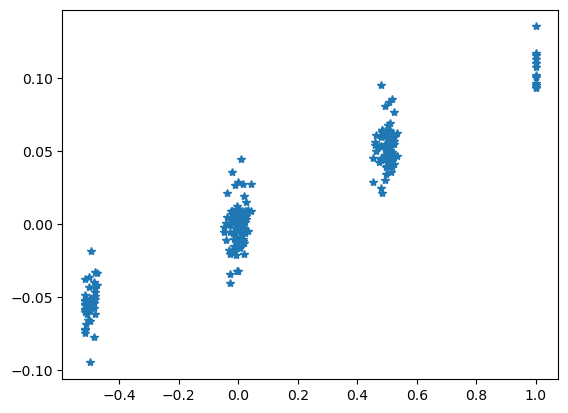

In [62]:
self_dot_mat = np.zeros([15, 15])
across_dot_mat = np.zeros([15, 15])
counter1 = -1
for theta1 in range(6):
    for theta2 in range(theta1):
        counter1 += 1
        counter2 = -1
        for theta1p in range(6):
            for theta2p in range(theta1p):
                counter2 += 1
                self_dot_mat[counter1, counter2] = difference_vectors[:,theta1, theta2, 0].T@difference_vectors[:,theta1p, theta2p, 0]/(np.linalg.norm(difference_vectors[:,theta1, theta2, 0])*np.linalg.norm(difference_vectors[:,theta1p, theta2p, 0]))
                across_dot_mat[counter1, counter2] = difference_vectors[:,theta1, theta2, 1].T@difference_vectors[:,theta1p, theta2p, 0]/(np.linalg.norm(difference_vectors[:,theta1, theta2, 1])*np.linalg.norm(difference_vectors[:,theta1p, theta2p, 0]))
plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(self_dot_mat,cmap='coolwarm')
#plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(across_dot_mat,cmap='coolwarm')
#plt.colorbar()

best_fitting_scale_parameter = np.sum(np.multiply(across_dot_mat, self_dot_mat))/np.sum(np.power(self_dot_mat, 2))
print(f'Best Fitting Scale Parameters: {best_fitting_scale_parameter}')

plt.figure()
plt.plot(np.ndarray.flatten(self_dot_mat), np.ndarray.flatten(across_dot_mat), '*')


Best Fitting Scale Parameters: 0.10690234491866549


(-0.1042247677398235, 0.1485791757683135)

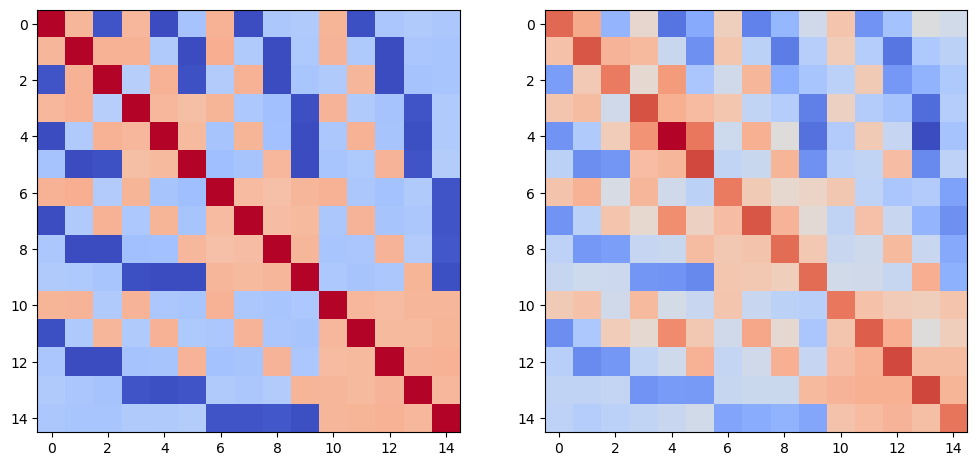

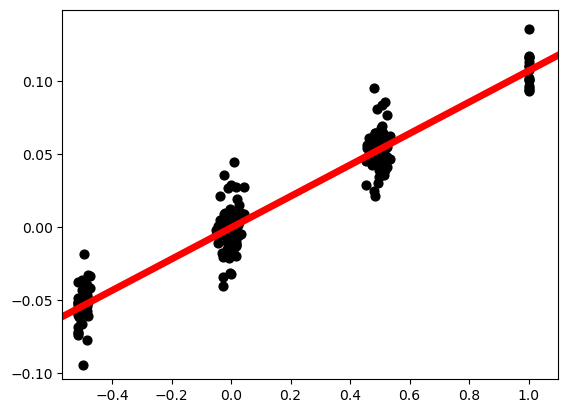

In [69]:
self_dot_mat = np.zeros([15, 15])
across_dot_mat = np.zeros([15, 15])
cosine_sim = 1
counter1 = -1
for theta1 in range(6):
    for theta2 in range(theta1):
        counter1 += 1
        counter2 = -1
        for theta1p in range(6):
            for theta2p in range(theta1p):
                counter2 += 1
                if cosine_sim == 0:
                    self_dot_mat[counter1, counter2] = difference_vectors[:,theta1, theta2, 0].T@difference_vectors[:,theta1p, theta2p, 0]
                    across_dot_mat[counter1, counter2] = difference_vectors[:,theta1, theta2, 1].T@difference_vectors[:,theta1p, theta2p, 0]
                else:
                    self_dot_mat[counter1, counter2] = difference_vectors[:,theta1, theta2, 0].T@difference_vectors[:,theta1p, theta2p, 0]/(np.linalg.norm(difference_vectors[:,theta1, theta2, 0])*np.linalg.norm(difference_vectors[:,theta1p, theta2p, 0]))
                    across_dot_mat[counter1, counter2] = difference_vectors[:,theta1, theta2, 1].T@difference_vectors[:,theta1p, theta2p, 0]/(np.linalg.norm(difference_vectors[:,theta1, theta2, 1])*np.linalg.norm(difference_vectors[:,theta1p, theta2p, 0]))
plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(self_dot_mat,cmap='coolwarm')
#plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(across_dot_mat,cmap='coolwarm')
#plt.colorbar()

best_fitting_scale_parameter = np.sum(np.multiply(across_dot_mat, self_dot_mat))/np.sum(np.power(self_dot_mat, 2))
print(f'Best Fitting Scale Parameters: {best_fitting_scale_parameter}')

plt.figure()
plt.scatter(np.ndarray.flatten(self_dot_mat), np.ndarray.flatten(across_dot_mat), c='k', s=40 )

b, m = np.poly1d(np.polyfit(np.ndarray.flatten(across_dot_mat), np.ndarray.flatten(self_dot_mat), 1))
x = np.ndarray.flatten(self_dot_mat)
y = np.ndarray.flatten(across_dot_mat)
offset = 1.5
plt.plot(np.hstack([np.min(x)*offset, np.unique(x), np.max(x)*offset]), np.poly1d(np.polyfit(x, y, 1))(np.hstack([np.min(x)*offset, np.unique(x), np.max(x)*offset])), lw = 5, c='r')
offset_2 =1.1
plt.xlim([np.min(x)*offset_2, np.max(x)*offset_2])
plt.ylim([np.min(y)*offset_2, np.max(y)*offset_2])



In [33]:
best_grad = np.poly1d(np.polyfit(np.ndarray.flatten(across_dot_mat), np.ndarray.flatten(self_dot_mat), 1))[1]
best_grad

11.366491859689356

In [34]:
from scipy import stats
stats.pearsonr(np.ndarray.flatten(across_dot_mat), np.ndarray.flatten(self_dot_mat))

PearsonRResult(statistic=0.9594205288902317, pvalue=1.3916185644794959e-124)

0.08075766941098692
11.347247987652095


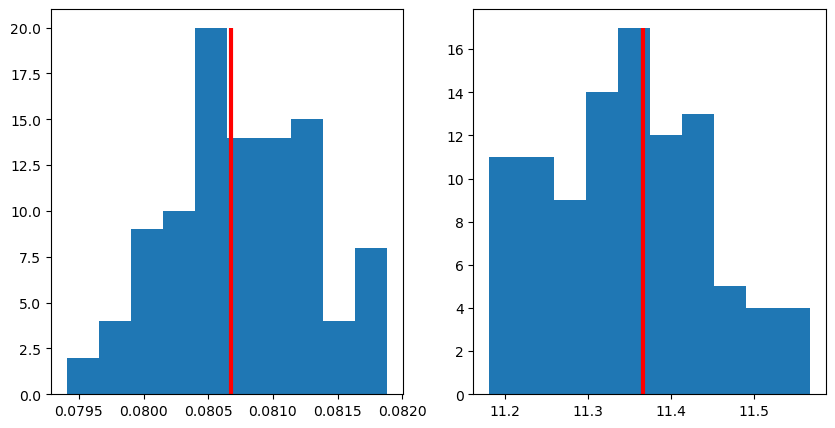

In [37]:
rand_runs = 100
scales = np.zeros([rand_runs])
polys = np.zeros([rand_runs])
for rand_run in range(rand_runs):
    noise_scale = np.sqrt(np.mean(np.power(g_delay_unbiased, 2)))/100
    g_delay_unbiased_noisy = g_delay_unbiased + np.random.normal(0, noise_scale, g_delay_unbiased.shape)
    subspace_angles, difference_vectors, g_encodings, projections = difference_analysis(g_delay_unbiased_noisy, regression_targets_unbiased, seq_len, num_stim, num_eigs = 5, fig = False)

    self_dot_mat = np.zeros([15, 15])
    across_dot_mat = np.zeros([15, 15])
    counter1 = -1
    for theta1 in range(6):
        for theta2 in range(theta1):
            counter1 += 1
            counter2 = -1
            for theta1p in range(6):
                for theta2p in range(theta1p):
                    counter2 += 1
                    self_dot_mat[counter1, counter2] = difference_vectors[:,theta1, theta2, 0].T@difference_vectors[:,theta1p, theta2p, 0]
                    across_dot_mat[counter1, counter2] = difference_vectors[:,theta1, theta2, 1].T@difference_vectors[:,theta1p, theta2p, 0]

    scales[rand_run] = np.sum(np.multiply(across_dot_mat, self_dot_mat))/np.sum(np.power(self_dot_mat, 2))
    polys[rand_run] = np.poly1d(np.polyfit(np.ndarray.flatten(across_dot_mat), np.ndarray.flatten(self_dot_mat), 1))[1]

plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
figey = plt.hist(scales)
biggest_count = np.max(figey[0])
plt.vlines(best_fitting_scale_parameter, 0, biggest_count, 'r', lw = 3)
print(np.mean(scales))

plt.subplot(1,2,2)
figey = plt.hist(polys)
biggest_count = np.max(figey[0])
plt.vlines(best_grad, 0, biggest_count, 'r', lw = 3)
print(np.mean(polys))


Best Fitting Scale Parameters: 0.08118433699924668


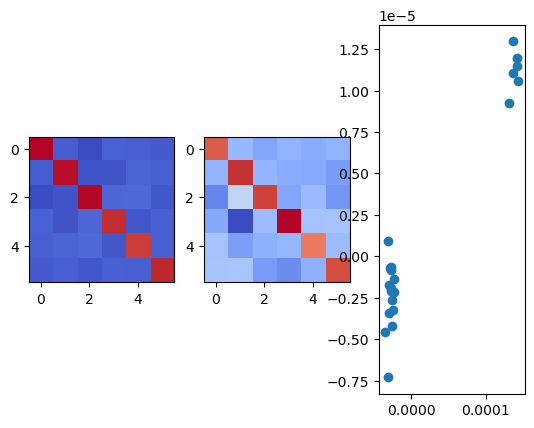

In [556]:
plt.subplot(1,3,1)
dot_1 = avg_rep[:,0,:].T@avg_rep[:,0,:]
plt.imshow(dot_1, cmap = 'coolwarm')

plt.subplot(1,3,2)
dot_2 = avg_rep[:,0,:].T@avg_rep[:,1,:]
plt.imshow(dot_2, cmap = 'coolwarm')

dot1 = dot_1[np.tril(dot_1) != 0]
dot2 = dot_2[np.tril(dot_1) != 0]

plt.subplot(1,3,3)
plt.scatter(dot1, dot2)

best_fitting_scale_parameter = np.sum(np.multiply(dot1, dot2))/np.sum(np.power(dot1, 2))
print(f'Best Fitting Scale Parameters: {best_fitting_scale_parameter}')

array([ 2.31411308e-04, -2.26471964e-05,  1.92737819e-04, -8.23233358e-05,
       -7.06102771e-05,  2.07836804e-04, -1.73577575e-05, -4.41488034e-05,
       -2.35292104e-05,  1.58733778e-04, -6.71825720e-05, -4.87313440e-05,
       -4.61581887e-06, -2.05155055e-05,  1.79772089e-04, -4.19004468e-05,
       -6.60019807e-06, -2.67581614e-05, -5.31825013e-05, -3.87268491e-05,
        1.67168157e-04])

0.060769555577636934


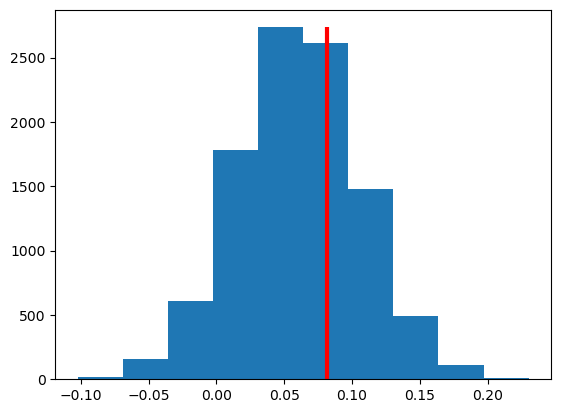

In [557]:
rand_runs = 10000
scales = np.zeros([rand_runs])
for rand_run in range(rand_runs):
    noise_scale = np.sqrt(np.mean(np.power(g_delay_unbiased, 2)))
    g_delay_unbiased_noisy = g_delay_unbiased + np.random.normal(0, noise_scale, g_delay_unbiased.shape)
    subspace_angles, difference_vectors, avg_rep_noisy = naive_analysis(g_delay_unbiased_noisy, regression_targets_unbiased, seq_len, num_stim, num_eigs = 5, fig = False)

    dot_1 = avg_rep_noisy[:,0,:].T@avg_rep_noisy[:,0,:]
    dot_2 = avg_rep_noisy[:,0,:].T@avg_rep_noisy[:,1,:]
    dot1 = dot_1[np.tril(dot_1) != 0]
    dot2 = dot_2[np.tril(dot_1) != 0]
    
    scales[rand_run] =  np.sum(np.multiply(dot1, dot2))/np.sum(np.power(dot1, 2))

figey = plt.hist(scales)
biggest_count = np.max(figey[0])
plt.vlines(best_fitting_scale_parameter, 0, biggest_count, 'r', lw = 3)
print(np.mean(scales))

Subspace Angles: [[75.61081802 77.00330924 82.86782444 84.88233365 87.71034359]]


81.6154471903832

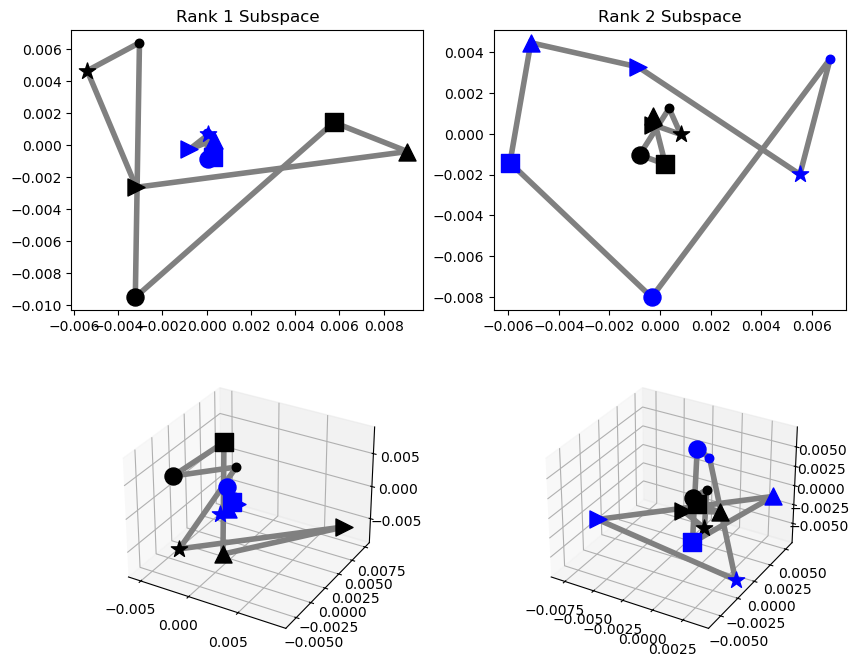

In [223]:
subspace_angles, difference_vectors, g_encodings, projections = difference_analysis(g_delay, regression_targets, seq_len, num_stim, num_eigs = 5)
mean_angles(subspace_angles[0,:])


In [23]:
subset = np.random.choice(30, [20], replace = False)
g_delay_subset = g_delay[:,subset]
regression_targets_subset = regression_targets[:,subset]

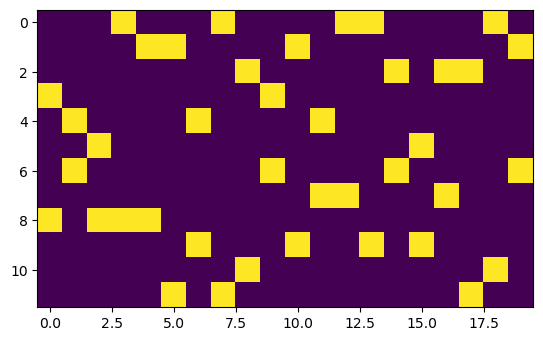

In [24]:
plt.imshow(regression_targets_subset)


Subspace Angles: [[44.13966436 49.02179474]]


46.58072954755116

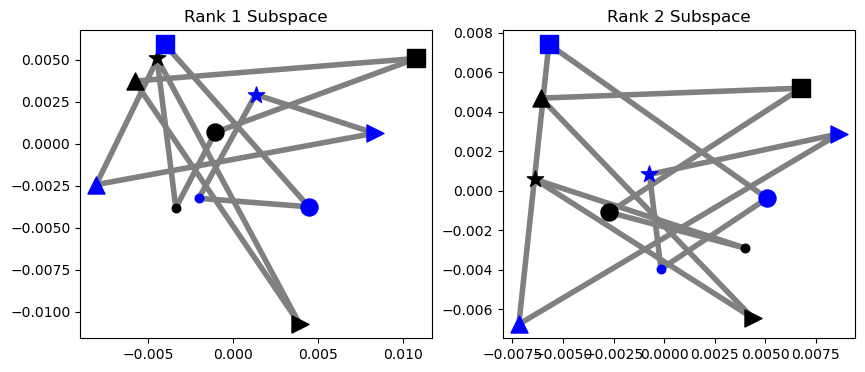

In [25]:


subspace_angles, difference_vectors, g_encodings, projections = difference_analysis(g_delay_subset, regression_targets_subset, seq_len, num_stim, num_eigs = 2)
mean_angles(subspace_angles[0,:])

Subspace Angles: [[80.68748064 89.68354824]]
85.18551443684514


ValueError: setting an array element with a sequence.

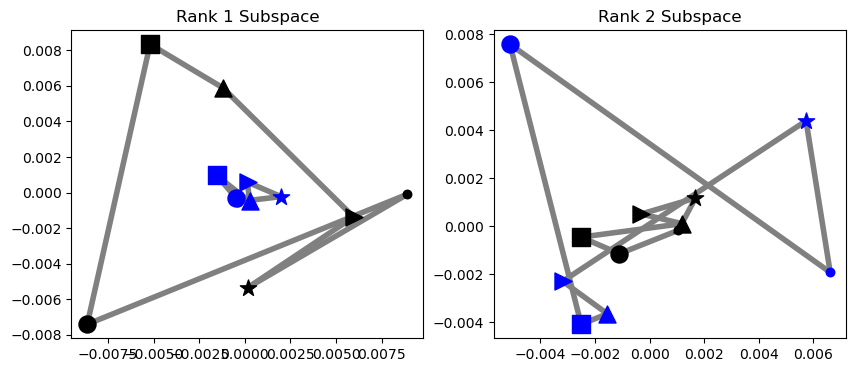

In [26]:
approx_size = np.mean(np.abs(g_delay))/1
noisy_g_delay = g_delay + np.random.normal(0, 1, g_delay.shape)*approx_size
subspace_angles, difference_vectors, g_encodings, projections = difference_analysis(noisy_g_delay, regression_targets, seq_len, num_stim, num_eigs = 2)

print(mean_angles(subspace_angles))

dot_plot(projections)

# What about biased data being put in?

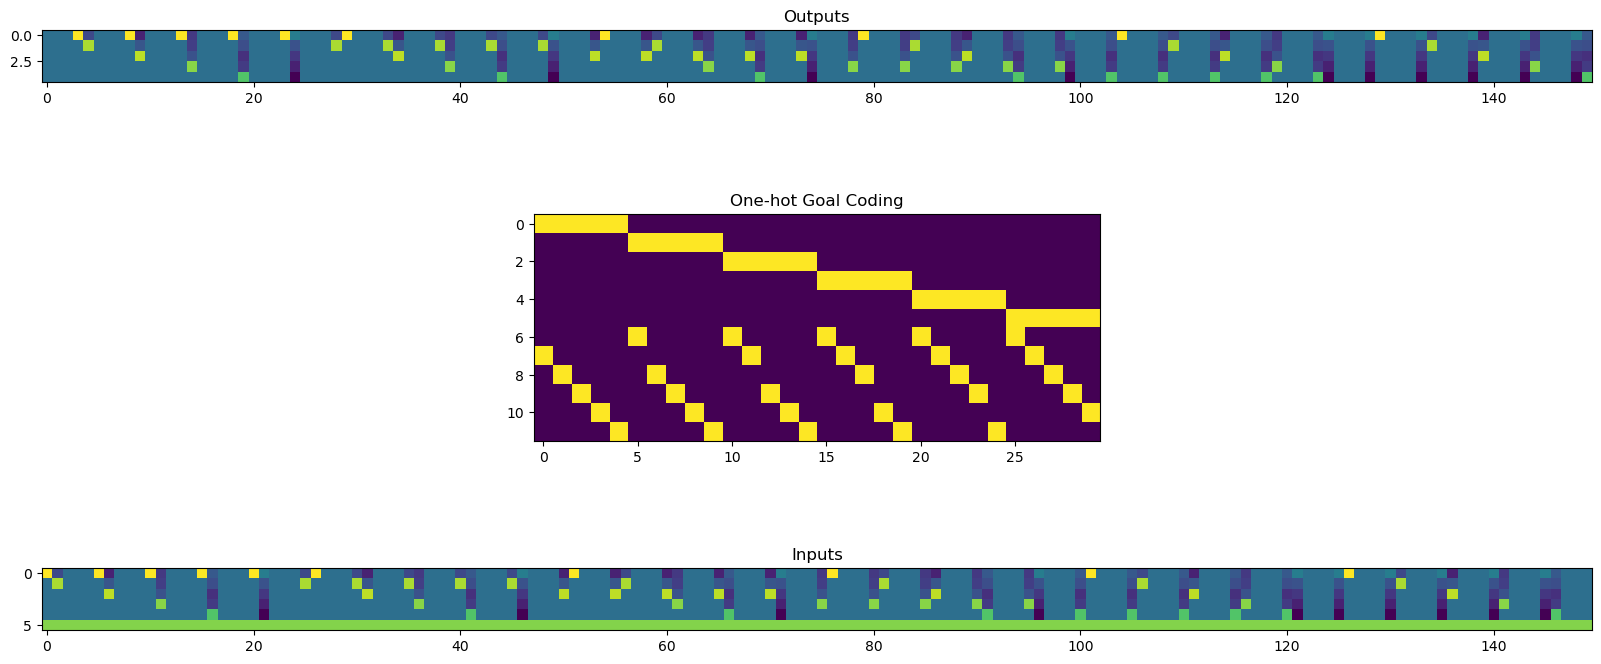

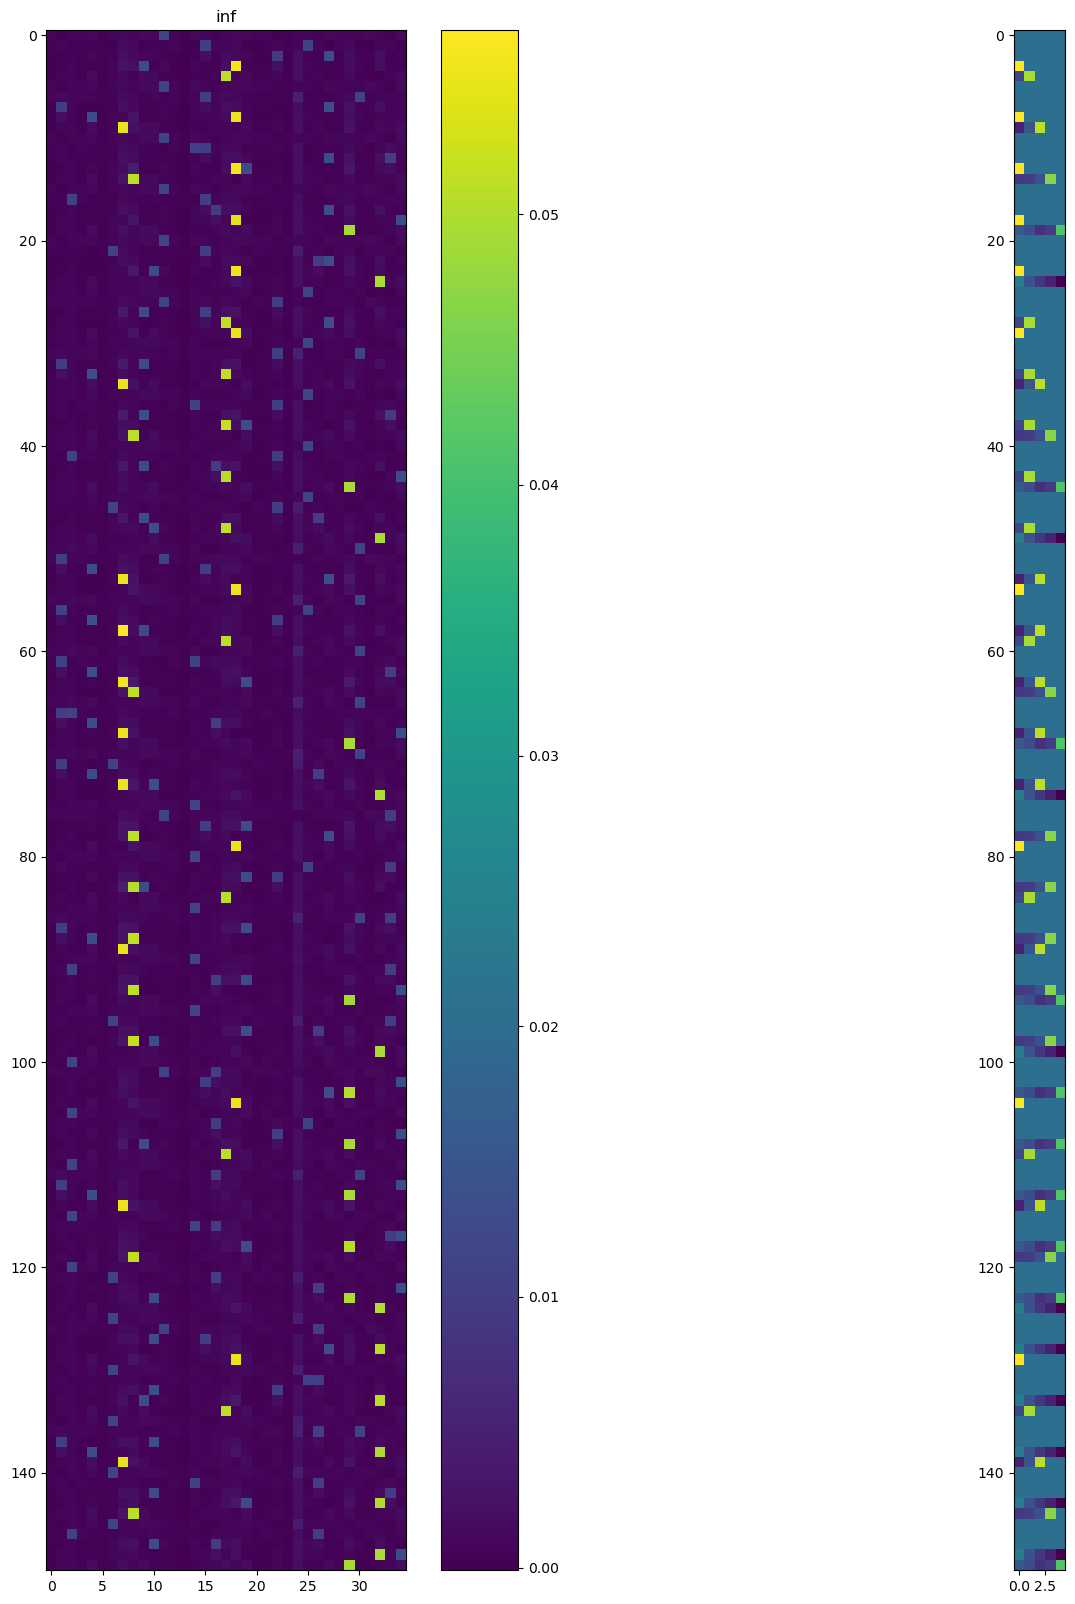

In [27]:
inputs_biased, outputs_biased, regression_targets_biased, D_biased, task_len = generate_sequences(generators, seq_len, 0, debias_outputs, debias_inputs)

g_biased = generate_rep_biased(params_best, inputs_biased)
R_biased = generate_R(g_biased, outputs_biased)

predictions_biased = R_biased.T@g_biased

plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(g_biased[:-bias,:].T)
plt.title(min_loss)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(predictions_biased.T)

g_delay_biased = g_biased[:-bias,seq_len::task_len]

Subspace Angles: [[70.87445799 71.46709312 71.62964016 73.07745661 74.21863969]]


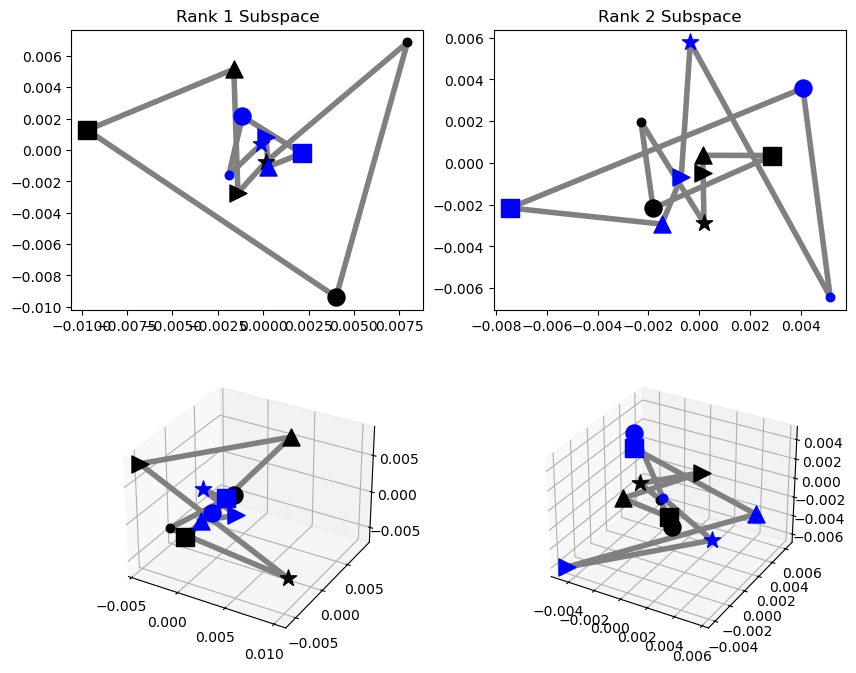

In [28]:
angles = naive_analysis(g_delay_biased, regression_targets_biased, seq_len, num_stim, num_eigs = 5)

Subspace Angles: [[81.57035082 82.93462848 84.49276356 84.65905833 85.17522614]]


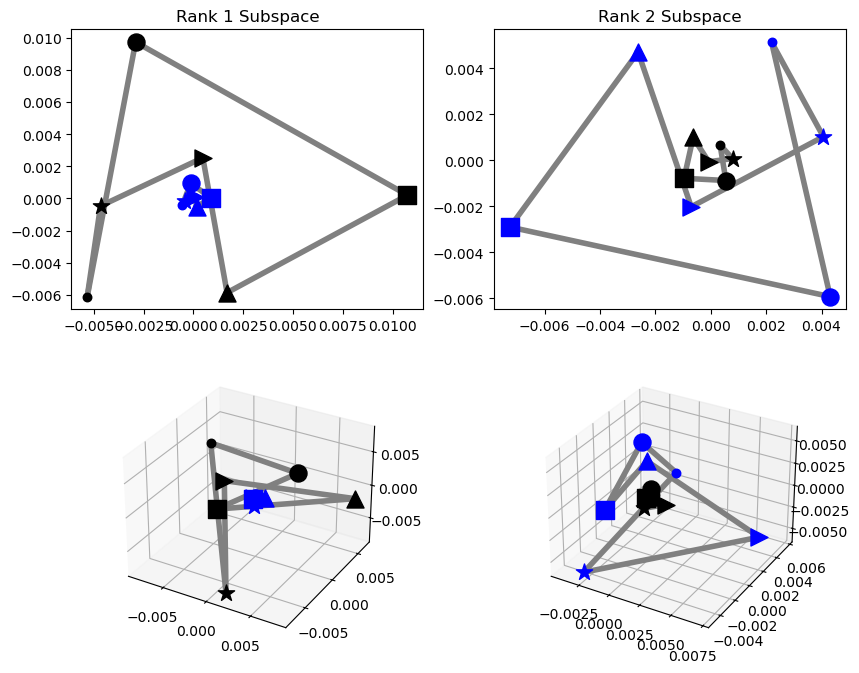

In [29]:
subspace_angles, difference_vectors, g_encodings, projections = difference_analysis(g_delay_biased, regression_targets_biased, seq_len, num_stim, num_eigs = 5)

# New Difference Analysis

Can we extract these subspaces from a severe subsampling?

For two subspaces, every time you have two trials with a repeat you can estimate a vector

For three, will have to have a think


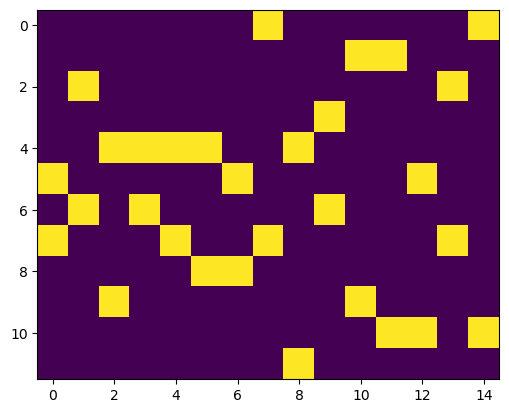

In [1020]:
num_subset = 15

subset = np.random.choice(30, [num_subset], replace = False)
g_delay_subset = g_delay[:,subset]
regression_targets_subset = regression_targets[:,subset]

plt.imshow(regression_targets_subset)

In [1021]:
# For each rank, go through and find all the pairs of trials during which that rank was the same
# This code only works for two ranks
num_eigs = 2
PCs = np.zeros([N, num_eigs, seq_len])
for rank in range(2):
    this_rank_estimates = []
    for q in range(num_stim):
        this_rank_this_stim_indices = np.where(regression_targets_subset[int(1-rank)*num_stim+q,:] == 1)[0]
        num_this_rank = len(this_rank_this_stim_indices)
        num_pairs =num_this_rank*(num_this_rank-1)

        for index1 in range(num_this_rank):
            for index2 in range(index1):
                difference = g_delay_subset[:,this_rank_this_stim_indices[index1]] - g_delay_subset[:,this_rank_this_stim_indices[index2]]
                this_rank_estimates.append(difference)
    this_rank_estimates = np.stack(this_rank_estimates).T

    PCs[:,:,rank] = get_2_PCs(this_rank_estimates, num_eigs = num_eigs)

# Let's get the subspace angles
subspace_angles = np.zeros([int((seq_len-1)*seq_len/2), num_eigs])
counter = 0
for r in range(seq_len):
    for r_p in range(r):
        dot_prod = PCs[:,:,r].T@PCs[:,:,r_p]
        U, S, V = np.linalg.svd(dot_prod)
        try:
            subspace_angles[counter, :] = np.arccos(S)/np.pi*180
        except:
            subspace_angles[counter,:] = S
        counter += 1

subspace_angles

array([[86.59196636, 86.85367509]])

In [1022]:
mean_angles(subspace_angles)

86.72282072596039

In [ ]:
Subspace Angles: [[81.57035082 82.93462848 84.49276356 84.65905833 85.17522614]]


In [637]:
# Now extract a couple of PCs and calculate the angles between them?
    PCs = np.zeros([N, num_eigs, seq_len])
    for r in range(seq_len):
        difference_vectors_flat = np.zeros([N, int(num_stim*(num_stim-1)/2)])
        counter = 0
        for q in range(num_stim):
            for qp in range(q):
                difference_vectors_flat[:,counter] = difference_vectors[:,q,qp,r]
                counter += 1
        PCs[:,:,r] = get_2_PCs(difference_vectors_flat, num_eigs = num_eigs)
    
    # Let's get the subspace angles
    subspace_angles = np.zeros([int((seq_len-1)*seq_len/2), num_eigs])
    counter = 0
    for r in range(seq_len):
        for r_p in range(r):
            dot_prod = PCs[:,:,r].T@PCs[:,:,r_p]
            U, S, V = np.linalg.svd(dot_prod)
            try:
                subspace_angles[counter, :] = np.arccos(S)/np.pi*180
            except:
                subspace_angles[counter,:] = S
            counter += 1

    # Finally, let's reconstruct the activity from these difference vectors
    g_encodings = np.zeros([N, num_stim, seq_len])
    projections = np.zeros([num_eigs, num_stim, seq_len, seq_len])
    for seq_ind in range(seq_len):
        g_encodings[:,:,seq_ind] = difference_vectors[:,0,:,seq_ind] - np.mean(difference_vectors[:,0,:,seq_ind],axis = 1)[:,None]

    for seq_ind in range(seq_len):
        for seq_indp in range(seq_len):
            projections[:,:,seq_ind, seq_indp] = PCs[:,:,seq_ind].T@g_encodings[:,:,seq_indp]
    
    markers = ['.','o','s','^','>','*']
    colours = ['k', 'b', 'r']

    if num_eigs%2 == 0:
        plot_3D = 0
    else:
        plot_3D = 1
    plot_rows = int(np.floor(num_eigs/2))
    
    fig = plt.figure(figsize = (10,4*plot_rows))
    for r in range(seq_len):
        for plot in range(plot_rows):
            if plot == plot_rows - 1 and plot_3D:
                num = plot_rows*100 + seq_len*10 + r+1+plot*plot_rows
                ax = fig.add_subplot(num, projection='3d')
                if plot == 0:
                    plt.title(f'Rank {r+1} Subspace')

                for rp in range(seq_len):
                    for q in range(num_stim):
                        ax.scatter(projections[0+2*plot,q,r,rp], projections[1+2*plot,q,r,rp], projections[2+2*plot,q,r,rp], s = 150, zorder=1, color = colours[rp], marker = markers[q])
                        ax.plot([projections[0+2*plot,q,r,rp], projections[0+2*plot,np.mod(q+1,num_stim),r,rp]], [projections[1+2*plot,q,r,rp], projections[1+2*plot,np.mod(q+1,num_stim),r,rp]], [projections[2+2*plot,q,r,rp], projections[2+2*plot,np.mod(q+1,num_stim),r,rp]], c='gray', lw = 4,zorder=0)

            else:
                plt.subplot(plot_rows,seq_len,r+1+plot*plot_rows)
                if plot == 0:
                    plt.title(f'Rank {r+1} Subspace')

                for rp in range(seq_len):
                    for q in range(num_stim):
                        plt.plot([projections[0+2*plot,q,r,rp], projections[0+2*plot,np.mod(q+1,num_stim),r,rp]], [projections[1+2*plot,q,r,rp], projections[1+2*plot,np.mod(q+1,num_stim),r,rp]], c='gray', lw = 4,zorder=0)
                        plt.scatter(projections[0+2*plot,q,r,rp], projections[1+2*plot,q,r,rp], s = 150, zorder=1, color = colours[rp], marker = markers[q])

    print(f'Subspace Angles: {subspace_angles}')
    

(35, 25)

# Final Exploration of Beta Analysis

Warning: section a bit rougher

In the actual Xie paper they don't do anything I've talked about so far, (as best I can understand) they analyse the regression weights between the average neural activity and a three hot encoding of the sequence. Let's do that, and show depending on how you set the regression hyperparameter you can get completely opposite results.


Change the lam value from 0.01 (perfect stuff) to 10 (super correlated things)

I don't know what they used, so can't really say much about the method...

One thing I can say, explored in the final cell, is that my current method of generating the true neural data is biased.

Currently, I take the regression weights from Xie, project through the 3-hot sequence encodings, and use those neural activities to do my analysis. This inherits all the bias that was used to create the regression weights, so is invalid! Sadly I need to extract calcium traces or something...

In [30]:
def naive_analysis_betas(beta_analysis, reg_tar, num_eigs = 2, fig = False):
    PCs = np.zeros([N,seq_len,num_eigs])
    
    for seq_ind in range(seq_len):
        PCs[:,seq_ind,:] = get_2_PCs(beta_analysis[:,seq_ind*num_stim:(seq_ind+1)*num_stim], num_eigs = num_eigs)
    
    projections = np.zeros([num_eigs,num_stim,seq_len,seq_len])
    for seq_ind in range(seq_len):
        for seq_ind2 in range(seq_len):
            projections[:,:,seq_ind,seq_ind2] = PCs[:,seq_ind,:].T@beta_analysis[:,seq_ind2*num_stim:(seq_ind2+1)*num_stim]


    # Let's get the subspace angles
    subspace_angles = np.zeros([int((seq_len-1)*seq_len/2), num_eigs])
    counter = 0
    for r in range(seq_len):
        for r_p in range(r):
            dot_prod = PCs[:,r,:].T@PCs[:,r_p,:]
            U, S, V = np.linalg.svd(dot_prod)
            try:
                subspace_angles[counter, :] = np.arccos(S)/np.pi*180
            except:
                subspace_angles[counter,:] = S
            counter += 1

    if fig:
        markers = ['.','o','s','^','>','*']
        colours = ['k', 'b', 'r']
        
        if num_eigs%2 == 0:
            plot_3D = 0
        else:
            plot_3D = 1
        plot_rows = int(np.floor(num_eigs/2))
        
        fig = plt.figure(figsize = (10,4*plot_rows))
        for r in range(seq_len):
            for plot in range(plot_rows):
                if plot == plot_rows - 1 and plot_3D:
                    num = plot_rows*100 + seq_len*10 + r+1+plot*plot_rows
                    ax = fig.add_subplot(num, projection='3d')
                    if plot == 0:
                        plt.title(f'Rank {r+1} Subspace')
    
                    for rp in range(seq_len):
                        for q in range(num_stim):
                            ax.scatter(projections[0+2*plot,q,r,rp], projections[1+2*plot,q,r,rp], projections[2+2*plot,q,r,rp], s = 150, zorder=1, color = colours[rp], marker = markers[q])
                            ax.plot([projections[0+2*plot,q,r,rp], projections[0+2*plot,np.mod(q+1,num_stim),r,rp]], [projections[1+2*plot,q,r,rp], projections[1+2*plot,np.mod(q+1,num_stim),r,rp]], [projections[2+2*plot,q,r,rp], projections[2+2*plot,np.mod(q+1,num_stim),r,rp]], c='gray', lw = 4,zorder=0)
    
                else:
                    plt.subplot(plot_rows,seq_len,r+1+plot*plot_rows)
                    if plot == 0:
                        plt.title(f'Rank {r+1} Subspace')
    
                    for rp in range(seq_len):
                        for q in range(num_stim):
                            plt.plot([projections[0+2*plot,q,r,rp], projections[0+2*plot,np.mod(q+1,num_stim),r,rp]], [projections[1+2*plot,q,r,rp], projections[1+2*plot,np.mod(q+1,num_stim),r,rp]], c='gray', lw = 4,zorder=0)
                            plt.scatter(projections[0+2*plot,q,r,rp], projections[1+2*plot,q,r,rp], s = 150, zorder=1, color = colours[rp], marker = markers[q])
    
        print(f'Subspace Angles: {subspace_angles}')
    return subspace_angles


# Then we need to do linear regression between these regressors and neural activity
lam = 1
reg_goals_1 = np.vstack([regression_targets, np.ones([1,regression_targets.shape[1]])])
beta = g_delay_biased@reg_goals_1.T@np.linalg.inv(np.eye(regression_targets.shape[0]+1)*lam + reg_goals_1@reg_goals_1.T)

angles = naive_analysis_betas(beta, regression_targets, num_eigs=5)
print(mean_angles(angles))

87.70814682761636


Subspace Angles: [[85.36626717 86.93291237 88.39612612 88.73185497 89.11311185]]


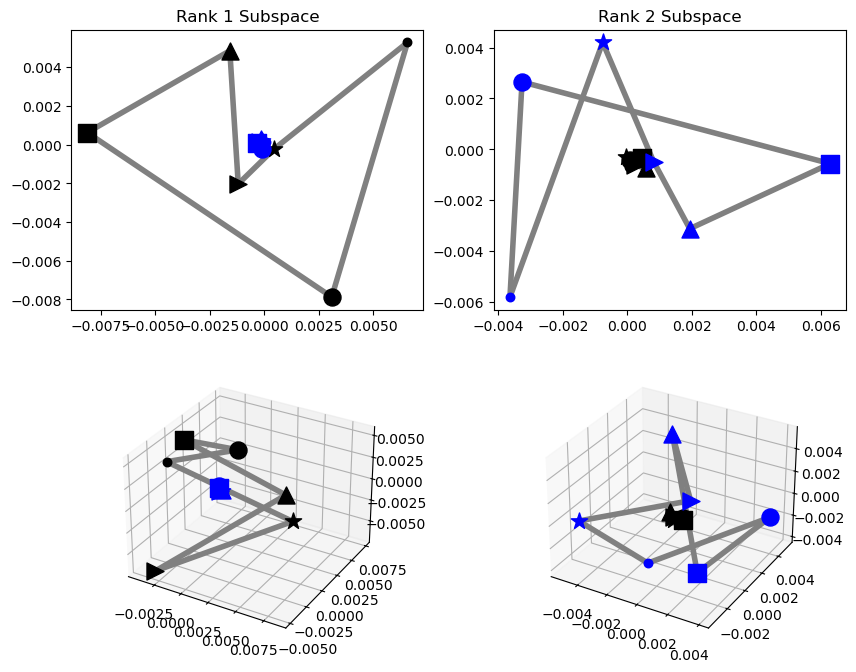

In [31]:
# So we now have some regression targets, let's 'recreate' unbiased neural data from it and see what happens
reg_goals_2 = np.vstack([regression_targets_unbiased, np.ones([1,regression_targets_unbiased.shape[1]])])
g_recreate = beta@reg_goals_2

angles = naive_analysis(g_recreate, regression_targets_unbiased, seq_len, num_stim, num_eigs = 5)

# Notice Antialignment! Not real effect!

Subspace Angles: [[81.57035082 82.93462848 84.49276356 84.65905833 85.17522614]]


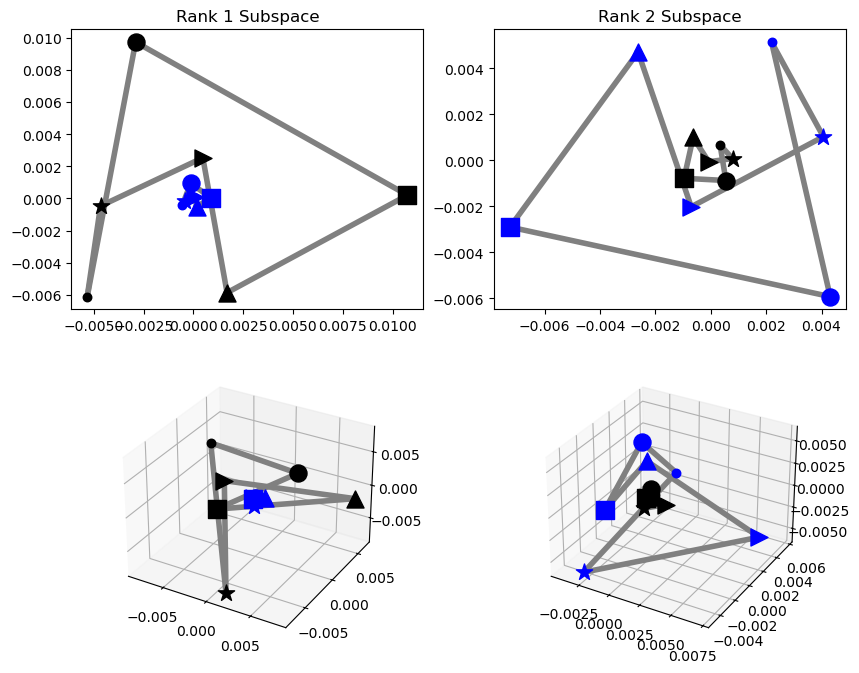

In [32]:
subspace_angles, difference_vectors, g_encodings, projections = difference_analysis(g_delay_biased, regression_targets_biased, seq_len, num_stim, num_eigs = 5)

# Let's try and do a more fair comparison of the beta vs. our method

In [74]:
# Create some fairly noisy data
noisy_copy_number = 2
noise_scale = 1
noise_size = np.mean(g_delay_biased)*noise_scale

g_delay_noisy = np.zeros([N, g_delay_biased.shape[1],noisy_copy_number])
for noisy_copy in range(noisy_copy_number):
    g_delay_noisy[:,:,noisy_copy] = g_delay_biased + np.random.normal(0, 1, g_delay_biased.shape)*noise_size

Subspace Angles: [[81.57035082 82.93462848 84.49276356 84.65905833 85.17522614]]


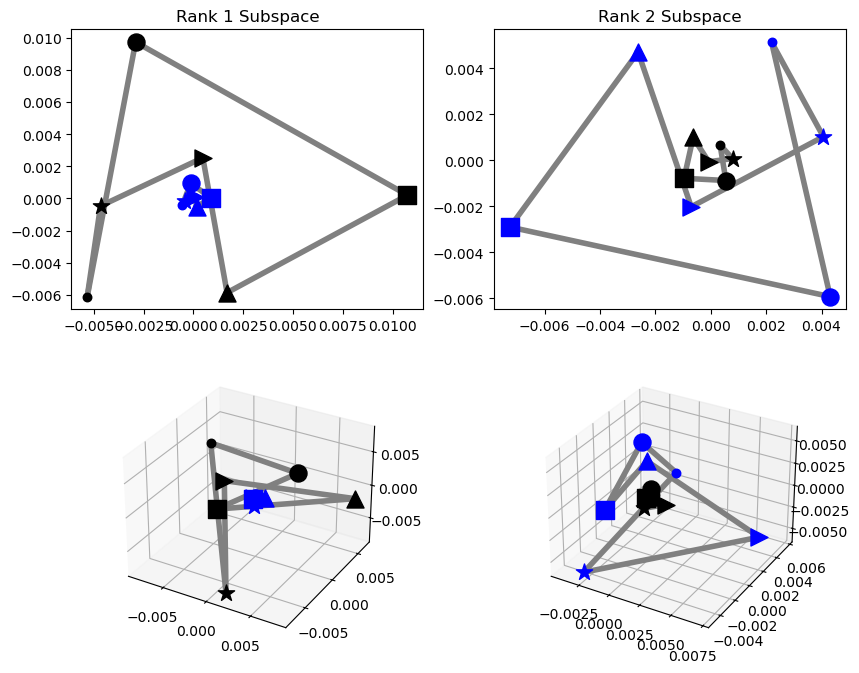

In [75]:
subspace_angles, difference_vectors, g_encodings, projections = difference_analysis(g_delay_biased, regression_targets_biased, seq_len, num_stim, num_eigs = 5)
mean_angle_true = mean_angles(subspace_angles)

In [76]:
random_samples = 1000
mean_angles_diff = np.zeros([random_samples])

regression_tar_noisy_stack = np.zeros([regression_targets.shape[0], regression_targets.shape[1]*noisy_copy_number])
for n in range(noisy_copy_number):
    regression_tar_noisy_stack[:,n*regression_targets.shape[1]:(n+1)*regression_targets.shape[1]] = regression_targets

for sample in range(random_samples):
    g_delay_noisy = np.zeros([N,  g_delay_biased.shape[1],noisy_copy_number])
    for noisy_copy in range(noisy_copy_number):
        g_delay_noisy[:,:,noisy_copy] = g_delay_biased + np.random.normal(0, 1, g_delay_biased.shape)*noise_size
    
    # Now just stick 'em together
    g_delay_noisy_stack = np.zeros([N, noisy_copy_number*g_delay_biased.shape[1]])
    for n in range(noisy_copy_number):
        g_delay_noisy_stack[:,n*g_delay.shape[1]:(n+1)*g_delay_biased.shape[1]] = g_delay_noisy[:,:,n]
    
    subspace_angles, difference_vectors, g_encodings, projections = difference_analysis(g_delay_noisy_stack, regression_tar_noisy_stack, seq_len, num_stim, num_eigs = 5, fig = False)
    mean_angles_diff[sample] = mean_angles(subspace_angles)

In [77]:
mean_angles_beta = np.zeros([random_samples])
reg_goals_1_noisy = np.vstack([regression_tar_noisy_stack, np.ones([1,regression_tar_noisy_stack.shape[1]])])
 
# First go through and extract the best fitting lambda
lams = [10, 8, 5, 3, 2, 1, 0.5, 0.3, 0.2, 0.1, 0.05, 0.03, 0.02, 0.01]

for sample in range(random_samples):
    g_delay_noisy = np.zeros([N, g_delay.shape[1],noisy_copy_number])
    for noisy_copy in range(noisy_copy_number):
        g_delay_noisy[:,:,noisy_copy] = g_delay_biased + np.random.normal(0, 1, g_delay_biased.shape)*noise_size
        
    min_error = np.inf
    for lam in lams:
        # Create beta_weights
        beta = g_delay_noisy[:,:,0]@reg_goals_1.T@np.linalg.inv(np.eye(regression_targets.shape[0]+1)*lam + reg_goals_1@reg_goals_1.T)
    
        # Measure error on held-out dataset
        g_predict = beta@reg_goals_1
        error = np.linalg.norm(g_delay_noisy[:,:,1] - g_predict)
    
        if error < min_error:
            min_error = error
            min_lam = lam

    # Now just stick 'em together
    g_delay_noisy_stack = np.zeros([N, noisy_copy_number*g_delay.shape[1]])
    for n in range(noisy_copy_number):
        g_delay_noisy_stack[:,n*g_delay.shape[1]:(n+1)*g_delay.shape[1]] = g_delay_noisy[:,:,n]


    beta = g_delay_noisy_stack@reg_goals_1_noisy.T@np.linalg.inv(np.eye(reg_goals_1_noisy.shape[0])*min_lam + reg_goals_1_noisy@reg_goals_1_noisy.T)
    
    angles = naive_analysis_betas(beta, regression_targets, num_eigs=5, fig = False)
    mean_angles_beta[sample] = mean_angles(angles)

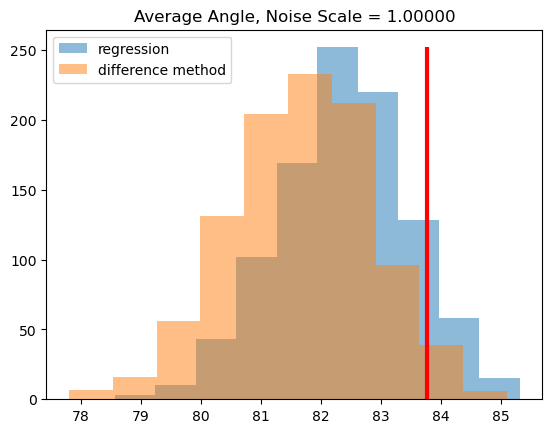

In [78]:
beta_fig = plt.hist(mean_angles_beta, label = 'regression', alpha = 0.5)
diff_fig = plt.hist(mean_angles_diff, label = 'difference method', alpha = 0.5)
biggest_count = max(np.max(beta_fig[0]), np.max(diff_fig[0]))
plt.vlines(mean_angle_true, 0, biggest_count, 'r', lw = 3)

plt.title(f'Average Angle, Noise Scale = {noise_scale:.5f}')
plt.legend()

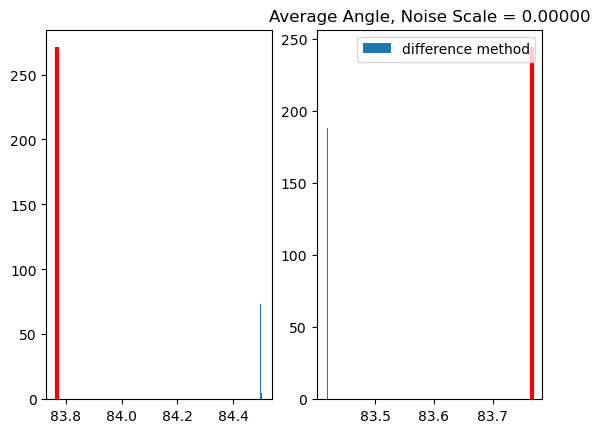

In [1144]:
plt.subplot(1,2,1)
beta_fig = plt.hist(mean_angles_beta, label = 'regression')
biggest_count = np.max(beta_fig[0])
plt.vlines(mean_angle_true, 0, biggest_count, 'r', lw = 3)



plt.subplot(1,2,2)
diff_fig = plt.hist(mean_angles_diff, label = 'difference method')
biggest_count = np.max(diff_fig[0])
plt.vlines(mean_angle_true, 0, biggest_count, 'r', lw = 3)

plt.title(f'Average Angle, Noise Scale = {noise_size:.5f}')
plt.legend()

In [1121]:
beta_fig

(array([  2.,  13.,  55., 164., 220., 261., 168.,  87.,  25.,   5.]),
 array([80.01317831, 80.01318688, 80.01319545, 80.01320401, 80.01321258,
        80.01322115, 80.01322971, 80.01323828, 80.01324685, 80.01325541,
        80.01326398]),
 <BarContainer object of 10 artists>)

array([  5.,  20.,  47., 116., 198., 258., 203., 116.,  29.,   8.])